---
# **LIBRARY**
---

In [43]:
# Library sistem
import os

# Library dasar
import numpy as np
import pandas as pd

# Library visualisasi
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Library statistika
from statsmodels.tsa.stattools import acf, pacf

# Library evaluasi
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

---
# **CONFIGURATION**
---

In [2]:
# ============================
# Configuration
# ============================
METADATA_PATH = "../data/processed/(K3 - Transformasi per jam) Beban listrik.csv" # Pastikan File telah ditambahkan
OUTPUT_PATH = "../hasil/ssa"

# Membuat direktori jika belum ada
os.makedirs(OUTPUT_PATH, exist_ok=True)
print(f"Output directory ready: {OUTPUT_PATH}")

Output directory ready: ../hasil/ssa


---
# **LOAD METADATA**
---

In [3]:
# Memanggil data
df_siap = pd.read_csv(METADATA_PATH)
df_siap['TANGGAL_JAM'] = pd.to_datetime(df_siap['TANGGAL_JAM'])
df_siap['TAHUN'] = df_siap['TANGGAL_JAM'].dt.year

df_siap.head()

TANGGAL_JAM     BEBAN  TAHUN
0 2016-01-01 00:00:00  5204.705   2016
1 2016-01-01 01:00:00  5208.790   2016
2 2016-01-01 02:00:00  5050.520   2016
3 2016-01-01 03:00:00  4873.250   2016
4 2016-01-01 04:00:00  4844.160   2016

---
## **1. Dekomposisi**
---

In [4]:
L = 168 # Panjang jendela 168 = (24*7)

In [7]:
SSA_DATA_PATH = f"{OUTPUT_PATH}/data"
SSA_KOMPONEN_PATH = f"{OUTPUT_PATH}/komponen"

os.makedirs(SSA_DATA_PATH, exist_ok=True)
os.makedirs(SSA_KOMPONEN_PATH, exist_ok=True)

### **Embadding**

In [6]:
def windowing(F: np.ndarray, L: int) -> np.ndarray:
    """
    Membentuk matriks trajectory SSA (windowing / embedding).

    Parameters
    ----------
    F : np.ndarray
        Deret waktu 1D, panjang N.
    L : int
        Panjang window (1 <= L <= N)

    Returns
    -------
    np.ndarray
        Matriks trajectory berukuran (L, K), dengan K = N - L + 1.
        Setiap kolom merepresentasikan vektor lag sepanjang L.
    """
    F = np.asarray(F).ravel()  # pastikan 1D
    N = len(F)
    if not (1 <= L <= N):
        raise ValueError("L harus antara 1 dan panjang data F.")
    K = N - L + 1
    X = np.column_stack([F[i:i + L] for i in range(K)])
    return X

In [14]:
X = windowing(df_siap['BEBAN'], L)
print(df_siap['BEBAN'].values)
print(X)

np.save(f'{OUTPUT_PATH}/X_{L}.npy', X)
np.savetxt(f'{OUTPUT_PATH}/X_{L}.csv', X, delimiter=',', fmt='%d')

[5204.705 5208.79  5050.52  ... 8455.14  7918.88  7510.35 ]
[[5204.705 5208.79  5050.52  ... 7640.71  7288.01  7078.5  ]
 [5208.79  5050.52  4873.25  ... 7288.01  7078.5   6934.38 ]
 [5050.52  4873.25  4844.16  ... 7078.5   6934.38  6816.52 ]
 ...
 [7347.71  6791.18  6189.06  ... 9305.29  9026.48  8455.14 ]
 [6791.18  6189.06  5877.48  ... 9026.48  8455.14  7918.88 ]
 [6189.06  5877.48  5644.61  ... 8455.14  7918.88  7510.35 ]]


### **Singular Value Decomposition (SVD)** 

In [16]:
# Fungsi dekomposisi
def dekomposisi(X, k=None):
  d = np.linalg.matrix_rank(X)
  U, Sigma, V = np.linalg.svd(X, full_matrices=False)
  V = V.T

  if k is None:
      k = d  # Gunakan semua komponen jika k tidak diberikan

  X_komponen = np.array([Sigma[i] * np.outer(U[:, i], V[:, i]) for i in range(k)])

  if not np.allclose(X, X_komponen.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

  return X_komponen, U, Sigma, V, d

# Fungsi hankelisasi
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # Hanya berlaku untuk matriks berukuran L < K.
        # Untuk L > K, maka ditranspose terlebih dahulu.
        # Memberikan tanda bahwa matriks ditranspose.
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))

    # Diagonal Averaging
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Membalik urutan X_i
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])


In [18]:
# Mendekompsisi matriks trajektori X
X_komponen, U, Sigma, V, d = dekomposisi(X)

In [22]:
print(U.shape)
print(Sigma.shape)
print(V.shape)

(168, 168)
(168,)
(77690, 168)


In [21]:
np.save(f'{SSA_DATA_PATH}/X_komponen.npy', X_komponen)
np.save(f'{SSA_DATA_PATH}/U.npy', U)
np.save(f'{SSA_DATA_PATH}/Sigma.npy', Sigma)
np.save(f'{SSA_DATA_PATH}/V.npy', V)
np.save(f'{SSA_DATA_PATH}/d.npy', d)

In [8]:
X_komponen = np.load(f'{SSA_DATA_PATH}/X_komponen.npy')
U = np.load(f'{SSA_DATA_PATH}/U.npy')
Sigma = np.load(f'{SSA_DATA_PATH}/Sigma.npy')
V = np.load(f'{SSA_DATA_PATH}/V.npy')
d = np.load(f'{SSA_DATA_PATH}/d.npy')

In [17]:
F_i = [X_to_TS(X_komponen[i]) for i in range(L)]  # Konversi semua komponen

In [9]:
t = range(len(df_siap.index))
colors = plt.get_cmap('tab20').colors

# Simpan setiap plot sebagai PNG dan PDF terpisah
for i in range(L):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(t, F_i[i], lw=2, color=colors[i % len(colors)])
    ax.set_title(f"Komponen {i}", fontsize=16)
    ax.set_xlabel("Waktu", fontsize=14)
    ax.set_ylabel("Nilai", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Simpan gambar PNG
    png_filename = os.path.join(SSA_KOMPONEN_PATH, f"komponen_{i}.png")
    plt.savefig(png_filename, dpi=300, bbox_inches="tight")

    # Simpan gambar PDF
    pdf_filename = os.path.join(SSA_KOMPONEN_PATH, f"komponen_{i}.pdf")
    plt.savefig(pdf_filename, dpi=300, bbox_inches="tight")

    plt.close(fig)

print(f"✅ Semua {L} plot telah disimpan sebagai PNG dan PDF di folder: {SSA_KOMPONEN_PATH}")

✅ Semua 168 plot telah disimpan sebagai PNG dan PDF di folder: ../hasil/ssa/komponen


---
## **2. Rekonstruksi**
---

In [27]:
SSA_REKONSTRUKSI_PATH = f"{OUTPUT_PATH}/rekonstruksi"
SSA_KELOMPOK_PATH = f"{SSA_REKONSTRUKSI_PATH}/kelompok"

os.makedirs(SSA_REKONSTRUKSI_PATH, exist_ok=True)
os.makedirs(SSA_KELOMPOK_PATH, exist_ok=True)

### **Eigntriple Grouping**

Tahap **eigentriple grouping** merupakan proses untuk **mengelompokkan, menjumlahkan, dan menginterpretasikan matriks elementer** yang telah diperoleh sebelumnya menjadi beberapa kelompok utama, yaitu **tren**, **periodik**, dan **noise**.

Langkah-langkah yang dilakukan pada tahap ini adalah sebagai berikut:

1. **Analisis Kontribusi Komponen**  
   Menganalisis **kontribusi kumulatif** dari masing-masing matriks singular ($\mathbf{X_i}$) untuk menentukan proporsi variasi data yang dijelaskan oleh setiap komponen.

2. **Analisis Mendalam**  
   Melakukan analisis lebih lanjut menggunakan:
   - Visualisasi komponen  
   - Matriks korelasi ($W$)  
   - Plot ACF (*Autocorrelation Function*)  
   - Pasangan *eigentriple* (*eigentriple pairs*)

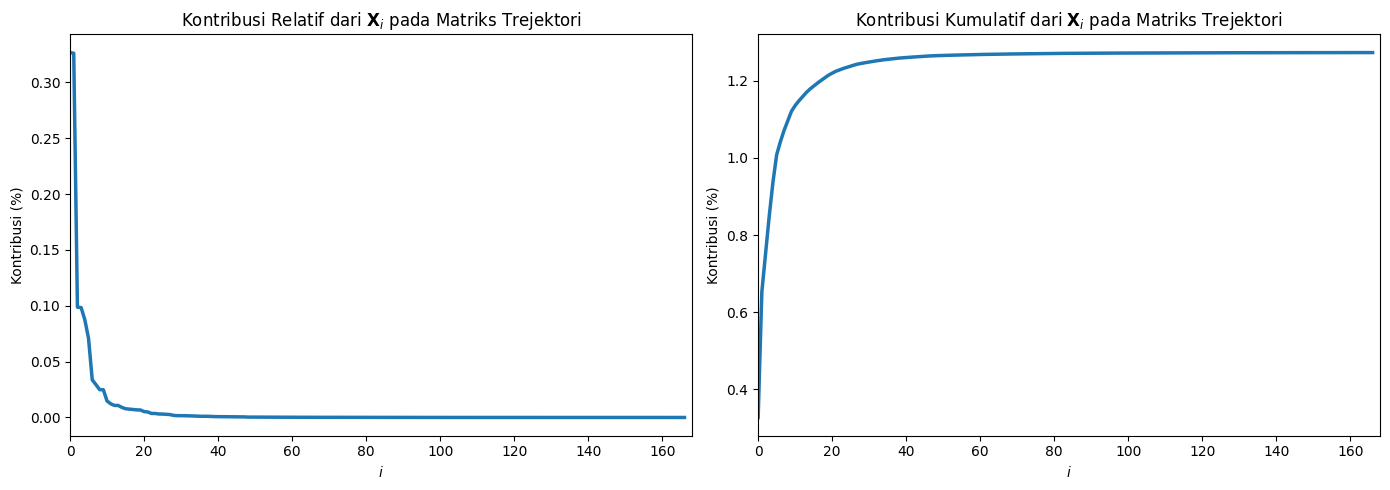

In [11]:
sigma_sumsq = (Sigma**2).sum()

# Membuat plot
fig, ax = plt.subplots(1, 2, figsize=(14,5))

# Plot kontribusi relatif
ax[0].plot(Sigma[1:]**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0, L)
ax[0].set_title("Kontribusi Relatif dari $\mathbf{X}_i$ pada Matriks Trejektori")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Kontribusi (%)")

# Plot kontribusi kumulatif
ax[1].plot((Sigma[1:]**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0, L)
ax[1].set_title("Kontribusi Kumulatif dari $\mathbf{X}_i$ pada Matriks Trejektori")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Kontribusi (%)")

plt.tight_layout()
plt.show()

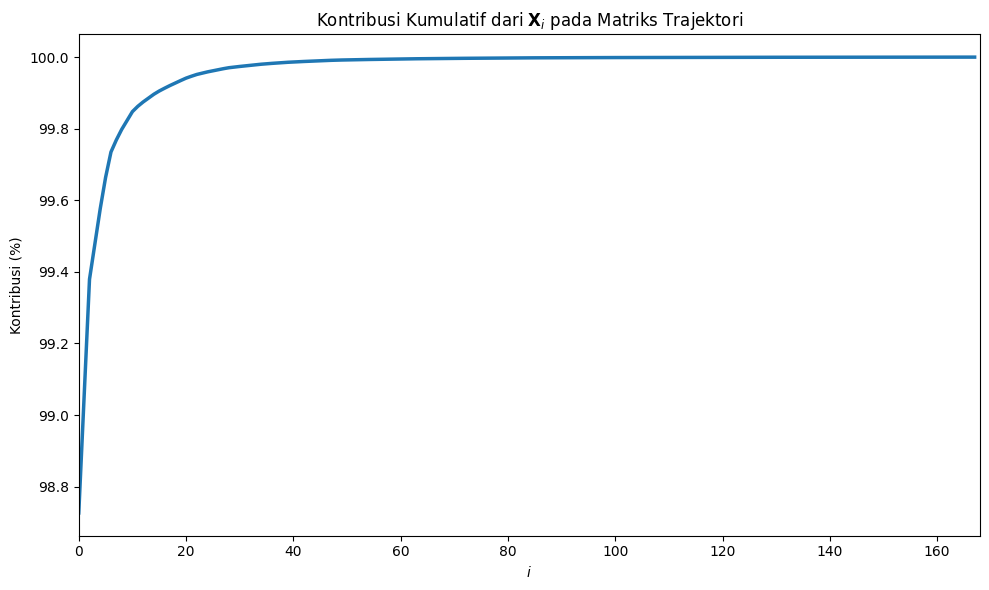

In [12]:
sigma_sumsq = (Sigma**2).sum()

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)

# Mengatur batas sumbu x
plt.xlim(0, L)
plt.title("Kontribusi Kumulatif dari $\mathbf{X}_i$ pada Matriks Trajektori")  # Perbaikan ejaan
plt.xlabel("$i$")
plt.ylabel("Kontribusi (%)")

plt.tight_layout()
plt.savefig(f"{SSA_REKONSTRUKSI_PATH}/Kontribusi_komulatif.png")
plt.savefig(f"{SSA_REKONSTRUKSI_PATH}/Kontribusi_komulatif.pdf")
plt.show()


Berdasarkan plot kontribusi kumulatif pada Gambar tersebut menunjukkan kurva *elbow* di sekitar 20 komponen pertama. 

Namun demikian, tetap perlu dilakukan analisis mendalam untuk dapat mengelompokkan dengan tepat.

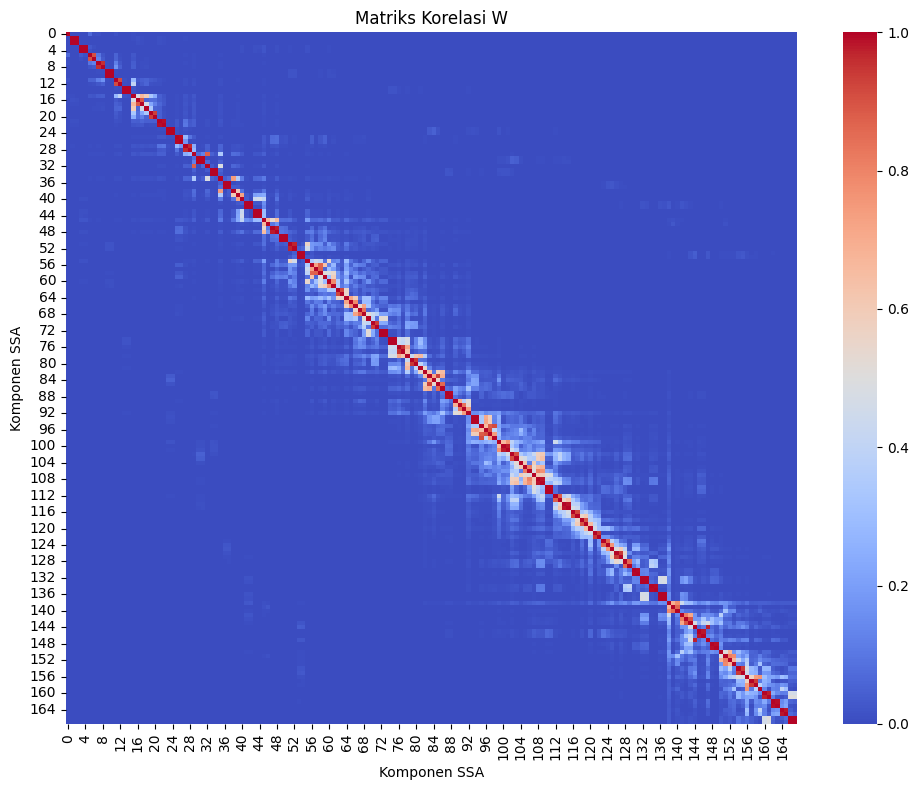

In [18]:
# Fungsi untuk menghitung matriks korelasi W-Coefficients
def w_correlation_matrix(F_i):
    n = len(F_i)
    W = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):  # Hanya menghitung setengah matriks
            W[i, j] = np.corrcoef(F_i[i], F_i[j])[0, 1]
            W[j, i] = W[i, j]  # Matriks simetris

    return W

# Hitung matriks korelasi W-Corr untuk komponen SSA
W = w_correlation_matrix(F_i)

# Plot matriks korelasi sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(W, cmap="coolwarm", annot=False)
plt.title("Matriks Korelasi W")
plt.xlabel("Komponen SSA")
plt.ylabel("Komponen SSA")
plt.tight_layout()

plt.savefig(f"{SSA_REKONSTRUKSI_PATH}/matriks_korelasi_w.png", dpi=300)
plt.savefig(f"{SSA_REKONSTRUKSI_PATH}/matriks_korelasi_w.pdf", dpi=300)

plt.show()

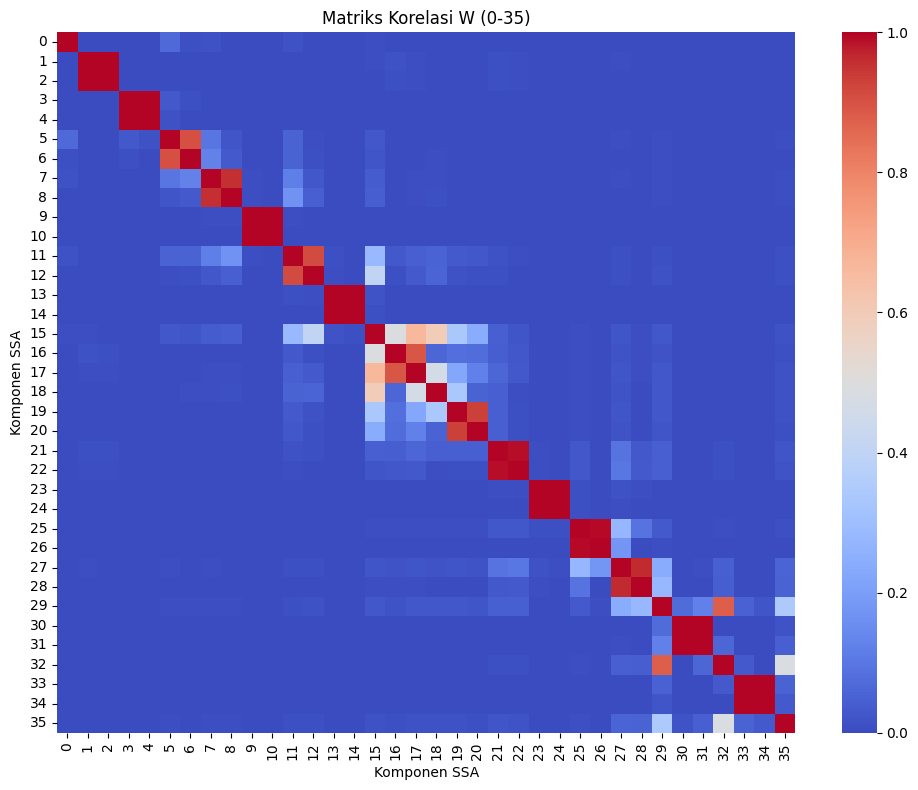

In [19]:
# Plot matriks korelasi sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(W[0:36,0:36], cmap="coolwarm", annot=False)
plt.title("Matriks Korelasi W (0-35)")
plt.xlabel("Komponen SSA")
plt.ylabel("Komponen SSA")
plt.tight_layout()

plt.savefig(f"{SSA_REKONSTRUKSI_PATH}/matriks_korelasi_w_35.png", dpi=300)
plt.savefig(f"{SSA_REKONSTRUKSI_PATH}/matriks_korelasi_w_35.pdf", dpi=300)

plt.show()

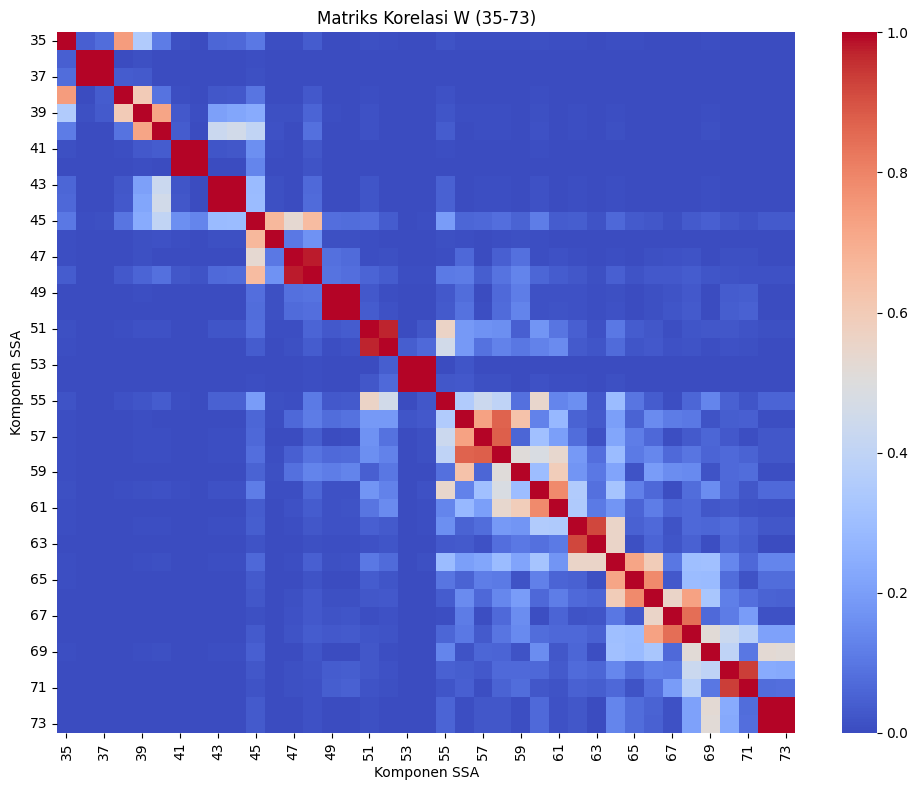

In [20]:
# Plot matriks korelasi sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(W[35:74,35:74], cmap="coolwarm", annot=False)
plt.xticks(ticks=np.arange(0.5, 39,2), labels=np.arange(35, 74,2))
plt.yticks(ticks=np.arange(0.5, 39,2), labels=np.arange(35, 74,2))
plt.title("Matriks Korelasi W (35-73)")
plt.xlabel("Komponen SSA")
plt.ylabel("Komponen SSA")
plt.tight_layout()

plt.savefig(f"{SSA_REKONSTRUKSI_PATH}/matriks_korelasi_w_73.png", dpi=300)
plt.savefig(f"{SSA_REKONSTRUKSI_PATH}/matriks_korelasi_w_73.pdf", dpi=300)

plt.show()

Berdasarkan matriks korelasi $W$, komponen-komponen SSA dapat dikelompokkan secara kasar ke dalam beberapa kelompok berdasarkan korelasi antar komponennya.

Selanjutnya akan dilihat lebih detail dengan mempertimbangkan plot komponen, plot acf, dan plot *eigentriple pairs*.

In [23]:
def cek_komponen(pasangan, zoom, title, include_f_0=True):
  kolom = 3
  baris = -(-len(pasangan) // kolom)
  n = len(U[:, pasangan[0][0]])

  plt.rcParams.update({'font.size': 14})

  # Plot F
  fig, axes = plt.subplots(baris, kolom, figsize=(12, 3.5 * baris), sharex=True, constrained_layout=True)
  axes = axes.flatten()
  for ax, (p1, p2) in zip(axes, pasangan):
      ax.plot(F_i[p1][zoom[0]:zoom[1]], lw=1, alpha=0.8, label=f"Komponen {p1}")
      ax.plot(F_i[p2][zoom[0]:zoom[1]], lw=1, alpha=0.8, label=f"Komponen {p2}")
      ax.set_title(f"Komponen {p1} dan {p2}", fontsize=17)
      ax.legend()
      ax.grid(True)
  for i in range(len(pasangan), len(axes)):
      fig.delaxes(axes[i])
  for ax in axes[-kolom:]:
      ax.set_xlabel("Waktu")
  for ax in axes:
      ax.set_ylabel("Nilai")
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_plot_komponen.pdf', dpi=300)
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_plot_komponen.png', dpi=300)
  plt.show()

  # Plot Scatter Pasangan U
  fig, axes = plt.subplots(baris, kolom, figsize=(12, 3.5 * baris), sharex=True, constrained_layout=True)
  axes = axes.flatten()
  for ax, (p1, p2) in zip(axes, pasangan):
      ax.scatter(U[:, p1], U[:, p2], label=f"[U{p1}, U{p2}]", alpha=0.5)
      ax.set_xlabel(f"U{p1}")
      ax.set_ylabel(f"U{p2}")
      ax.set_title(f"U{p1} vs U{p2}", fontsize=17)
      ax.grid(True)

  for i in range(len(pasangan), len(axes)):
    fig.delaxes(axes[i])

  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_scatter_komponen.pdf', dpi=300)
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_scatter_komponen.png', dpi=300)
  plt.show()

  # Mengitung ACF dan batas signifikansinya
  acf_ = []
  ci = 1.96 / np.sqrt(n) # Batas signifikansi ±1.96/sqrt(N)
  for sepasang in pasangan:
    temp_1 = acf(U[:,sepasang[0]], nlags=50)
    temp_2 = acf(U[:,sepasang[1]], nlags=50)
    acf_.append([temp_1, temp_2])

  # Plot ACF
  fig, axes = plt.subplots(-(-len(pasangan) // 2), 4, figsize=(12, 2 * -(-len(pasangan) // 2)), constrained_layout=True)
  axes = axes.flatten()

  subplot_idx = 0
  for (acf1, acf2), (p1, p2) in zip(acf_, pasangan):
      # Plot ACF untuk p1
      ax1 = axes[subplot_idx]
      ax1.stem(acf1)
      ax1.axhline(ci, linestyle="dashed", color="gray")
      ax1.axhline(-ci, linestyle="dashed", color="gray")
      ax1.set_title(f"ACF U{p1}", fontsize=17)
      ax1.grid(True)
      subplot_idx += 1

      # Plot ACF untuk p2
      ax2 = axes[subplot_idx]
      ax2.stem(acf2)
      ax2.axhline(ci, linestyle="dashed", color="gray")
      ax2.axhline(-ci, linestyle="dashed", color="gray")
      ax2.set_title(f"ACF U{p2}", fontsize=17)
      ax2.grid(True)
      subplot_idx += 1

  # Hapus subplot kosong jika ada
  for i in range(subplot_idx, len(axes)):
      fig.delaxes(axes[i])

  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_acf_komponen.pdf', dpi=300)
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_acf_komponen.png', dpi=300)
  plt.show()

  # Hasil penggabungan
  flattened = [item for sublist in pasangan for item in sublist]
  print(flattened)

  F_rekonstruksi = 0
  for i in flattened:
    F_rekonstruksi += F_i[i]

  if include_f_0:
    F_rekonstruksi = F_rekonstruksi + F_i[0]

  plt.figure(figsize=(12, 6))
  if include_f_0:
    plt.plot(df_siap['TANGGAL_JAM'][zoom[0]:zoom[1]], df_siap['BEBAN'][zoom[0]:zoom[1]], lw=1)
  plt.plot(df_siap['TANGGAL_JAM'][zoom[0]:zoom[1]], F_rekonstruksi[zoom[0]:zoom[1]], lw=1)
  plt.title('Data kelompok terhadap data asli')
  plt.xlabel('Waktu')
  plt.ylabel('Nilai')
  plt.xticks(rotation=45)
  plt.legend(['Data Asli', 'Data Kelompok'])
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_rekonstruksi_komponen.pdf', dpi=300)
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_rekonstruksi_komponen.png', dpi=300)
  plt.show()

def rekonstruk(komponen, zoom, title, include_f_0=True):
  F_rekonstruksi = 0

  for i in komponen:
    F_rekonstruksi += F_i[i]
  if include_f_0 and 0 not in komponen:
    F_rekonstruksi = F_rekonstruksi + F_i[0]

  plt.figure(figsize=(12, 6))
  plt.plot(df_siap['TANGGAL_JAM'][zoom[0]:zoom[1]], F_rekonstruksi[zoom[0]:zoom[1]], lw=1.5, color='C1')
  if include_f_0:
    plt.plot(df_siap['TANGGAL_JAM'][zoom[0]:zoom[1]], df_siap['BEBAN'][zoom[0]:zoom[1]], lw=1.5, color='C0')
  plt.xlabel('Waktu')
  plt.ylabel('Nilai')
  plt.title(f"Plot kelompok {title}")
  plt.xticks(rotation=45)
  plt.legend(['Data kelompok', 'Data Asli'])
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_rekonstruksi.pdf', dpi=300)
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_rekonstruksi.png', dpi=300)

  if include_f_0 and 0 not in komponen:
    F_rekonstruksi = F_rekonstruksi-F_i[0]
  return F_rekonstruksi

In [25]:
def cek_komponen_tren(indeks_data, zoom, title, include_f_0=True):
  n = len(U[:, indeks_data])

  plt.rcParams.update({'font.size': 14})

  # Mengitung ACF dan batas signifikansinya
  acf_ = acf(U[:,indeks_data], nlags=50)
  ci = 1.96 / np.sqrt(n) # Batas signifikansi ±1.96/sqrt(N)

  # Plot F
  fig = plt.figure(figsize=(12, 3.5), constrained_layout=True)
  plt.plot(F_i[indeks_data][zoom[0]:zoom[1]], lw=1, alpha=0.8, label=f"Komponen {indeks_data}")
  plt.title(f"Komponen {indeks_data}", fontsize=17)
  plt.legend()
  plt.grid(True)
  plt.xlabel("Waktu")
  plt.ylabel("Nilai")
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_plot_komponen.pdf', dpi=300)
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_plot_komponen.png', dpi=300)
  plt.show()

  # Plot U
  fig = plt.figure(figsize=(12, 3.5), constrained_layout=True)
  plt.scatter(U[:, 0], U[:, 1], label=f"[U{0}, U{1}]", alpha=0.5)
  plt.xlabel(f"U{0}")
  plt.ylabel(f"U{1}")
  plt.title(f"U{0} vs U{1}", fontsize=17)
  plt.grid(True)
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_scatter_komponen.pdf', dpi=300)
  plt.savefig(f'{SSA_KELOMPOK_PATH}/{title}_scatter_komponen.png', dpi=300)
  plt.show()

---
#### **Tren**
---

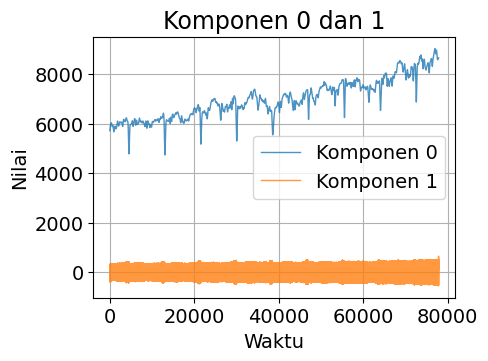

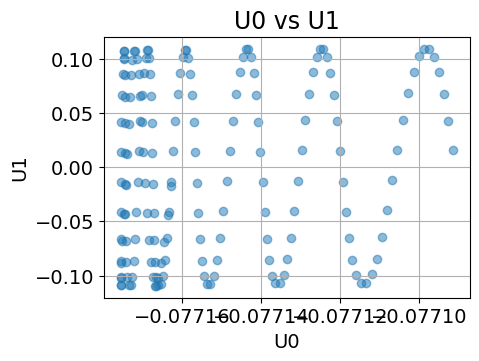

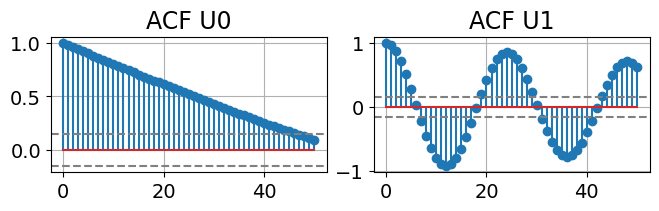

[0, 1]


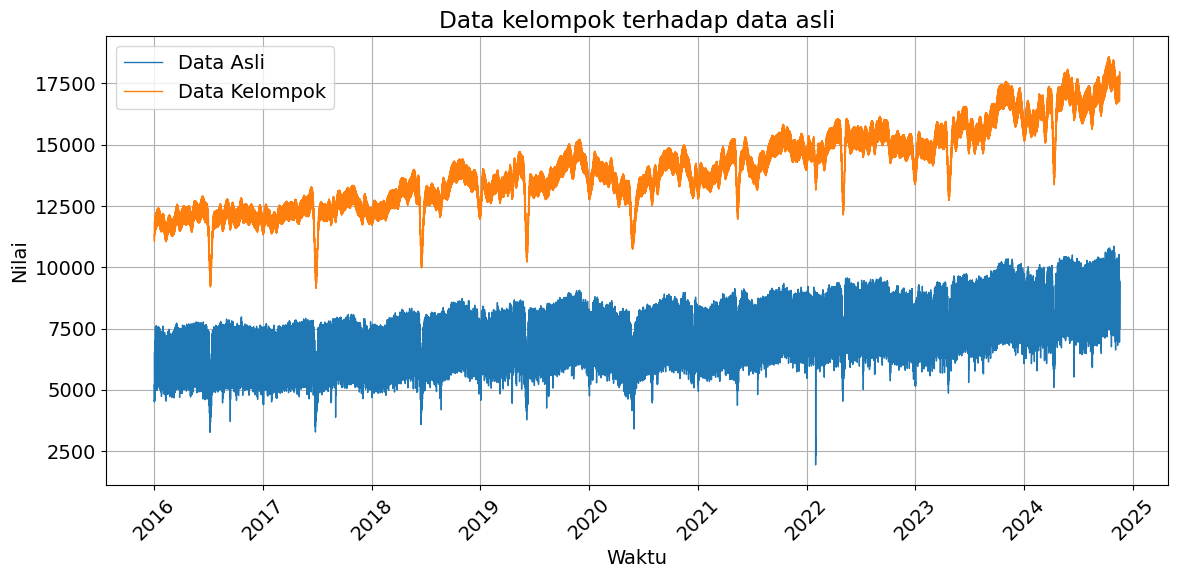

In [28]:
# Tren
pasangan = [
    [0,1]
]
zoom = [0,0+24*100000]

cek_komponen(pasangan, zoom, "kel_tren")

---
#### **Jam**
---

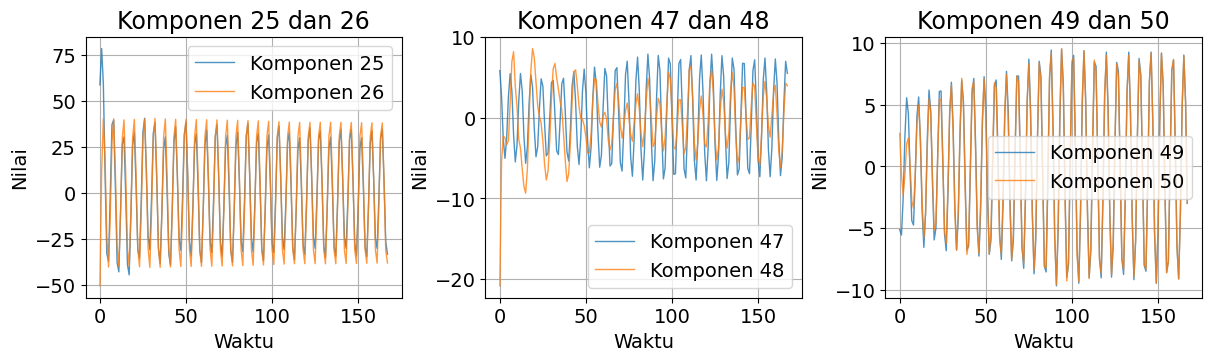

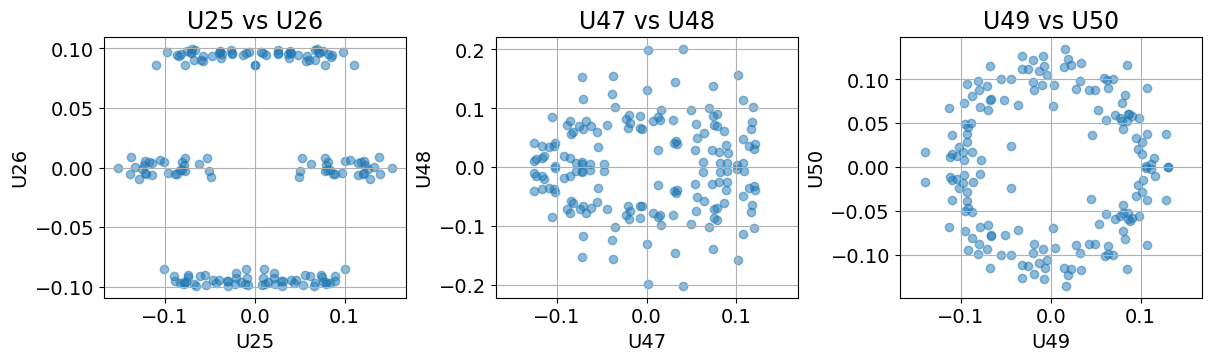

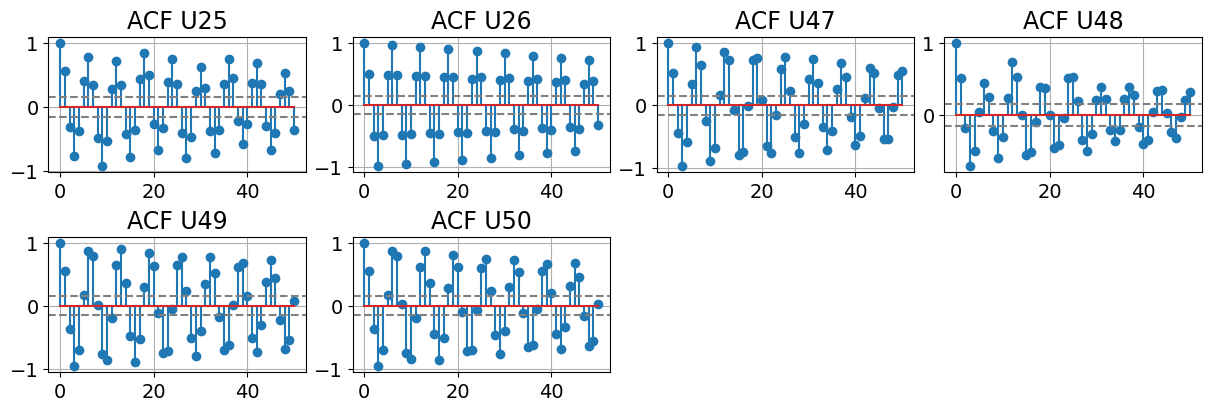

[25, 26, 47, 48, 49, 50]


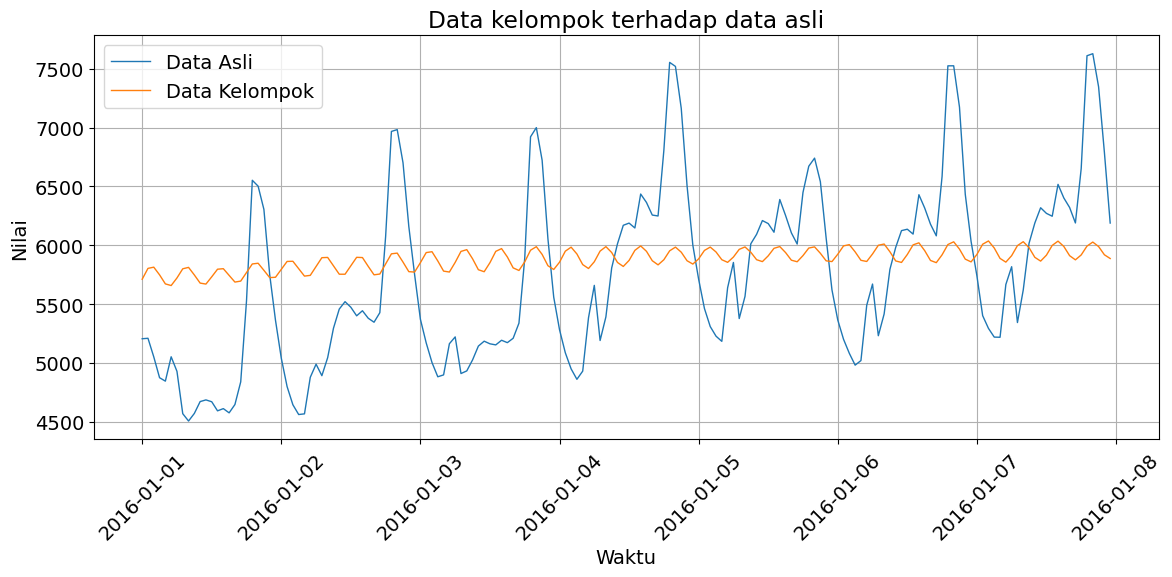

In [29]:
# jam 1
pasangan = [
    [25,26],
    [47,48],
    [49,50]
]
zoom = [0,0+24*7]

cek_komponen(pasangan, zoom, "kel_jam1")

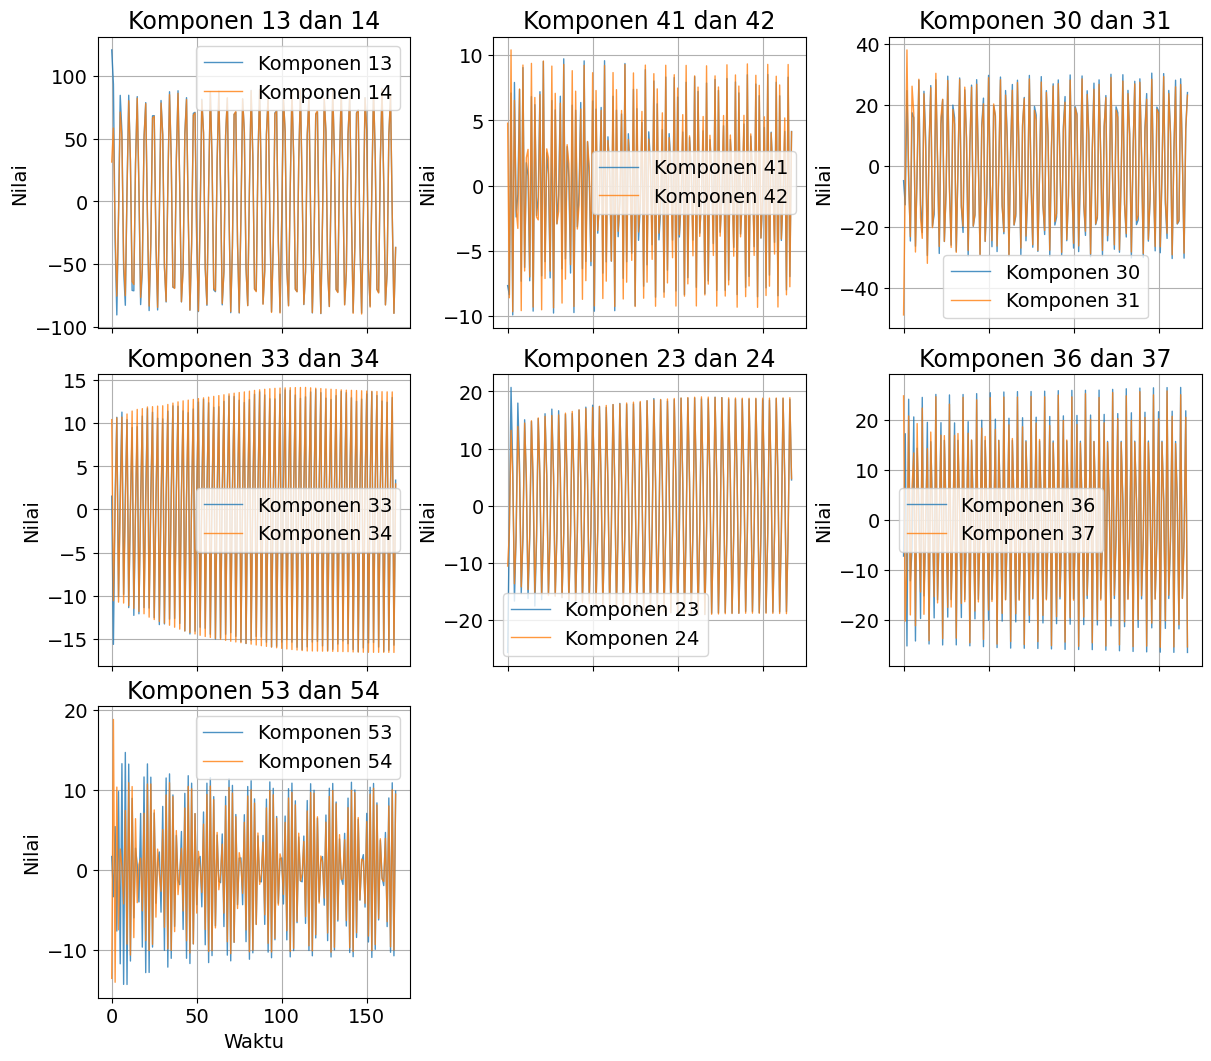

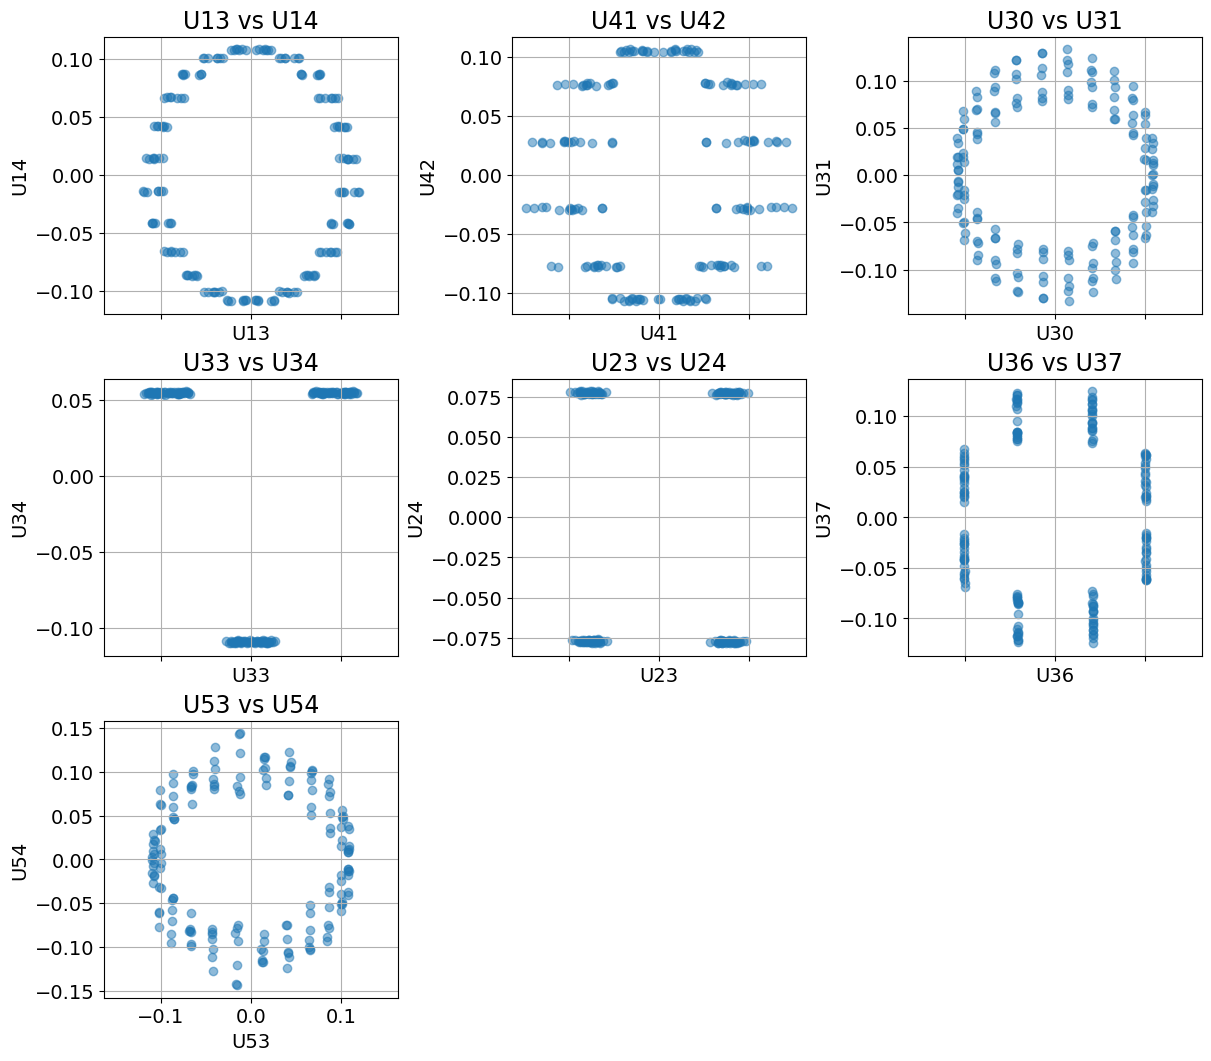

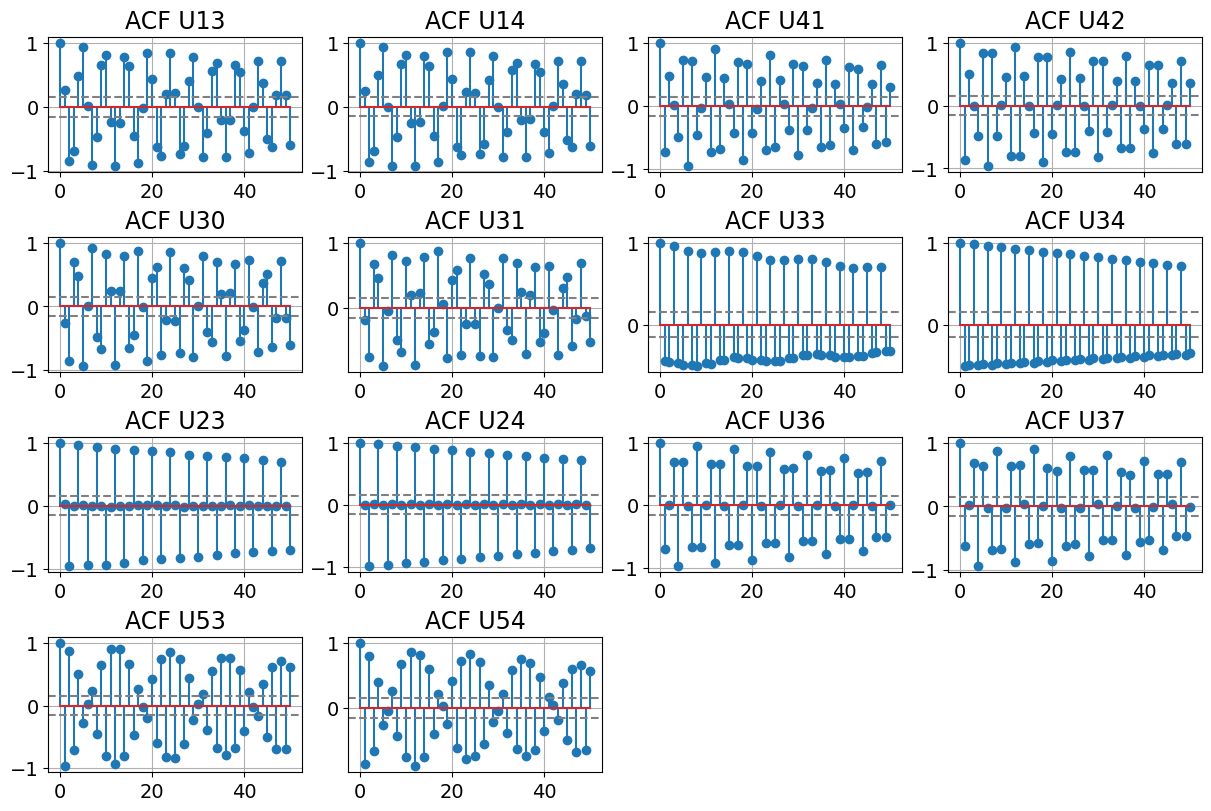

[13, 14, 41, 42, 30, 31, 33, 34, 23, 24, 36, 37, 53, 54]


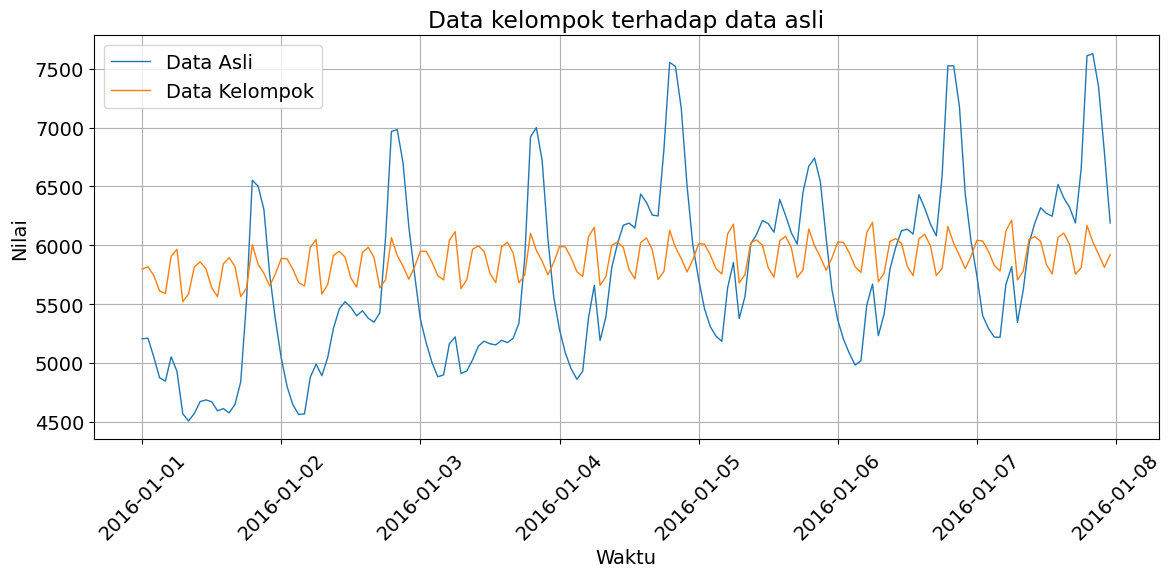

In [30]:
# jam 2
pasangan = [
    [13,14],
    [41,42],
    [30,31],
    [33,34],
    [23,24],
    [36,37],
    [53,54]
]
zoom = [0,24*7]

cek_komponen(pasangan, zoom, "kel_jam2")

---
#### **Harian**
---

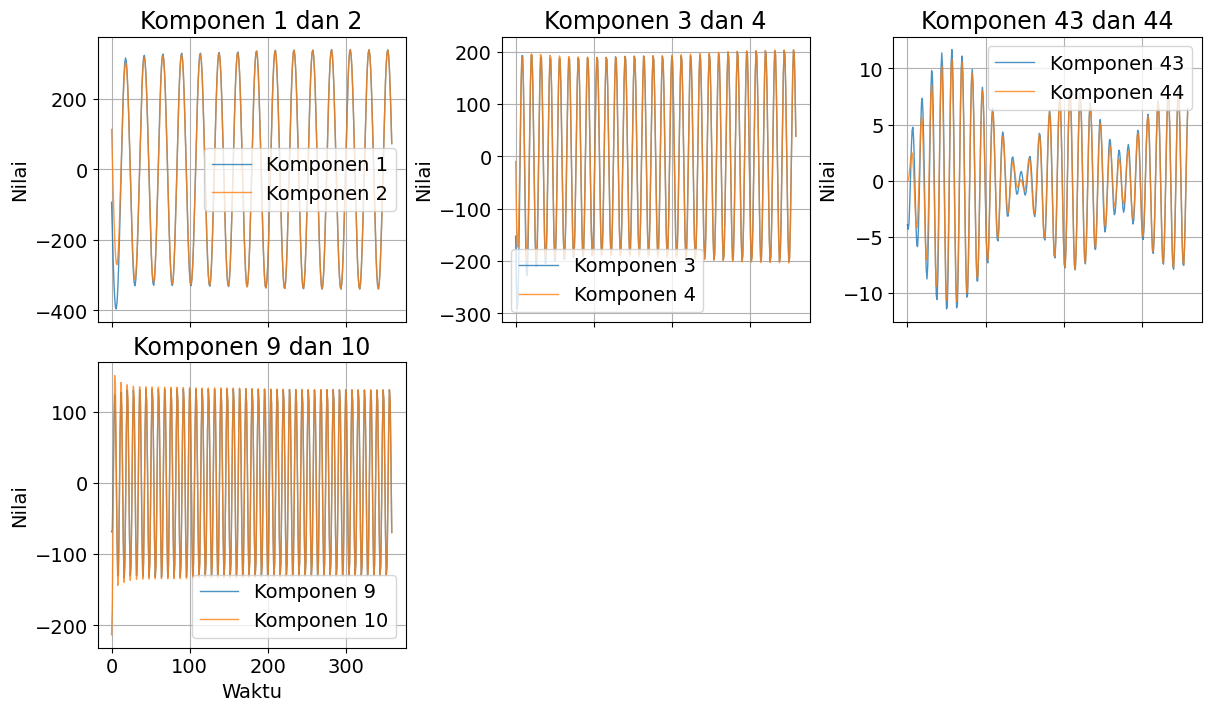

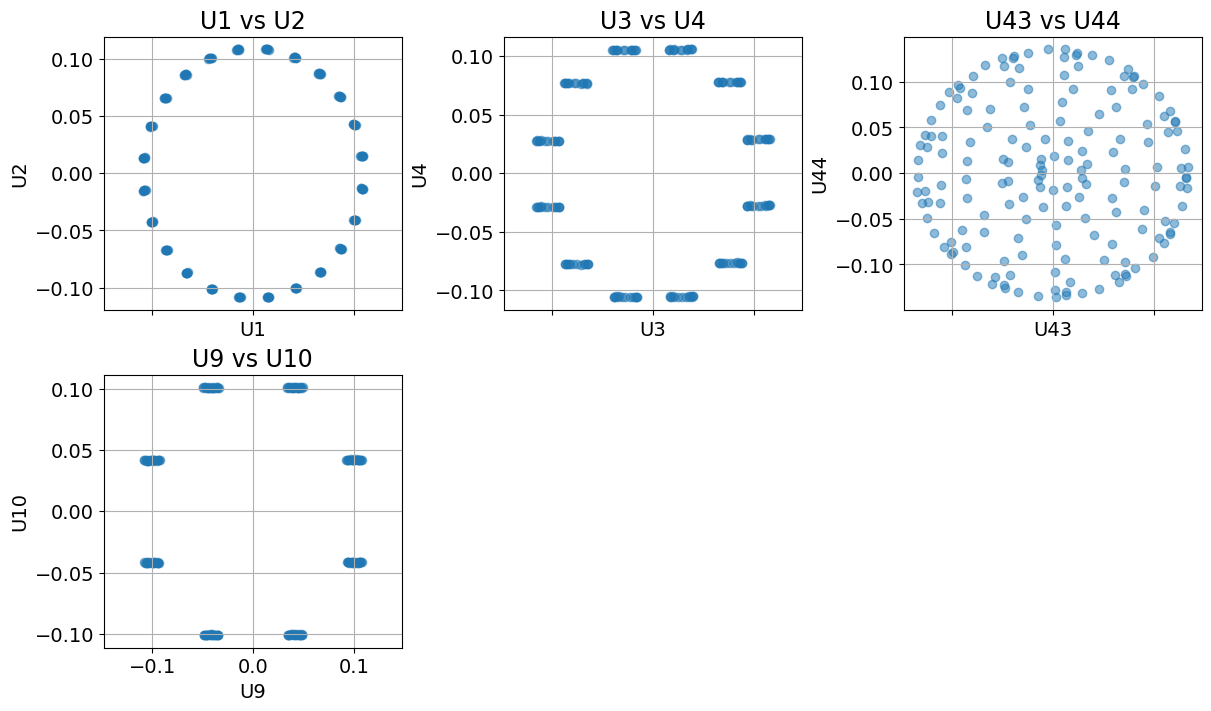

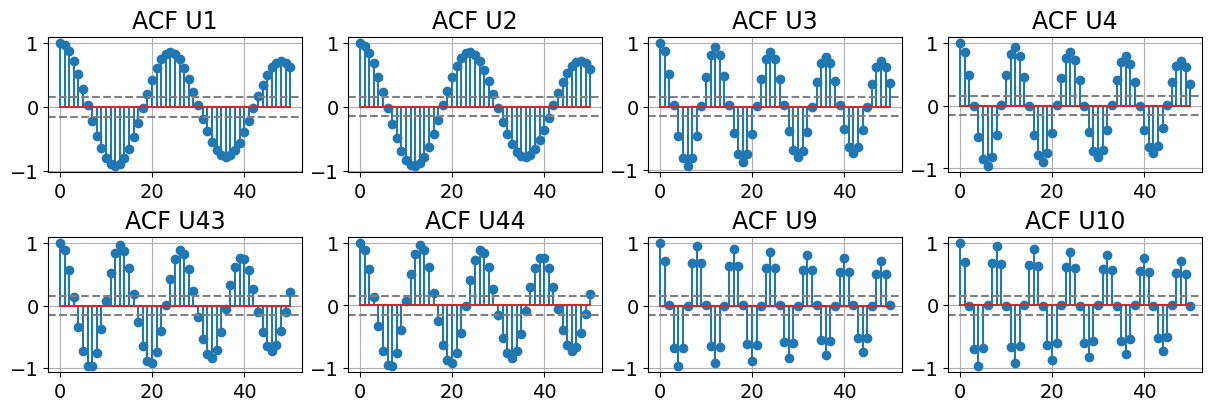

[1, 2, 3, 4, 43, 44, 9, 10]


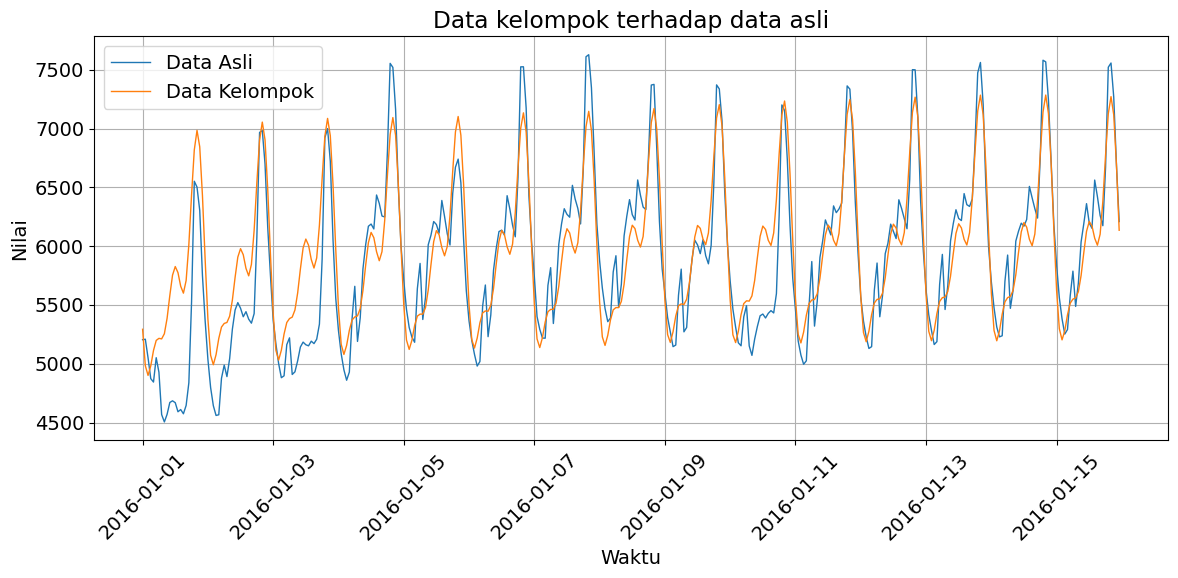

In [32]:
# harian 1
pasangan = [
    [1,2],
    [3,4],
    [43,44],
    [9,10]

]
zoom = [0,0+24*15]

cek_komponen(pasangan, zoom, "kel_harian1")

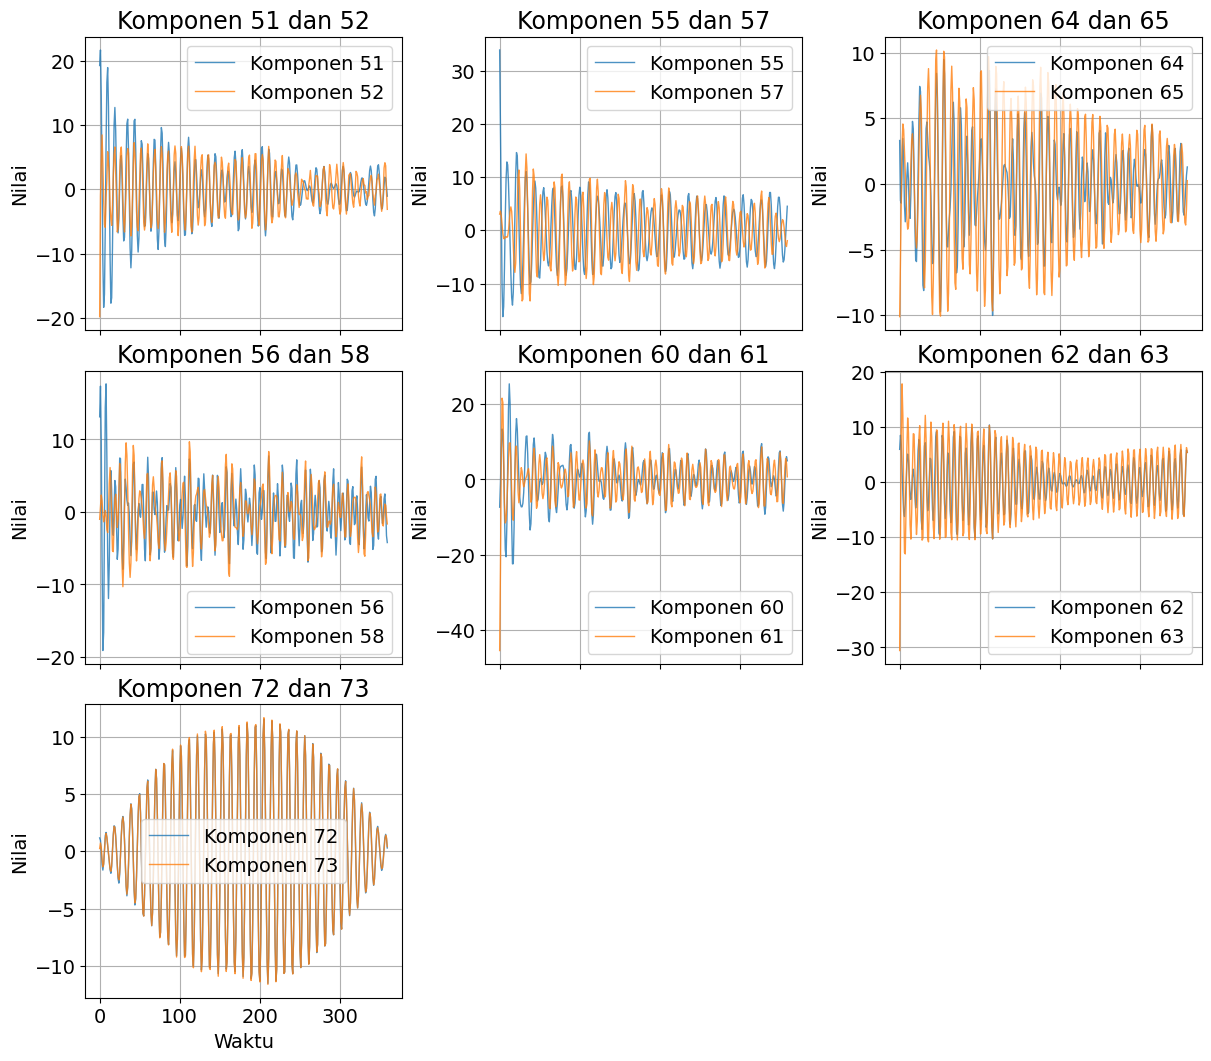

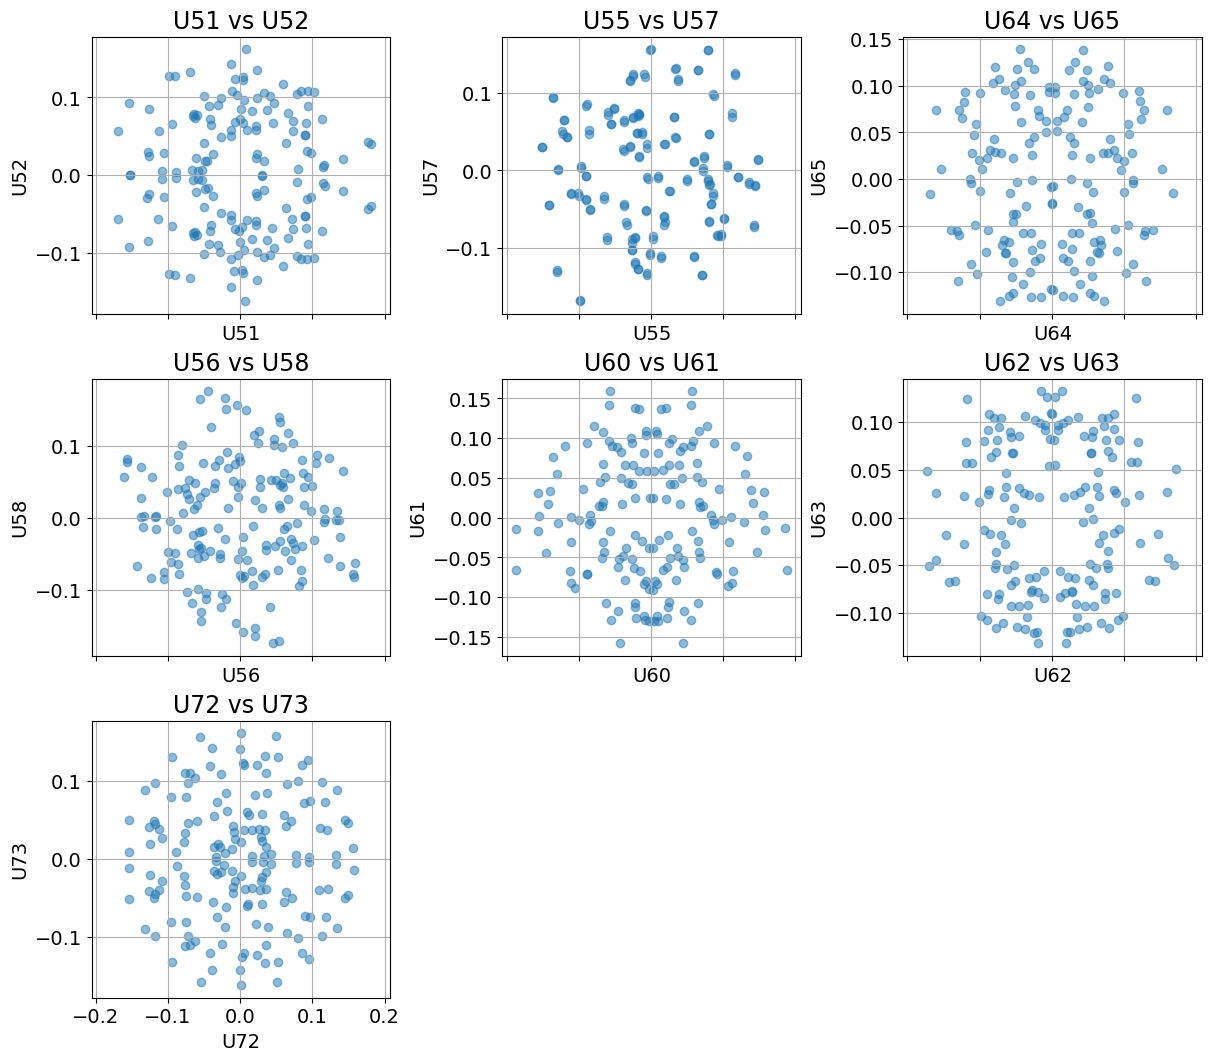

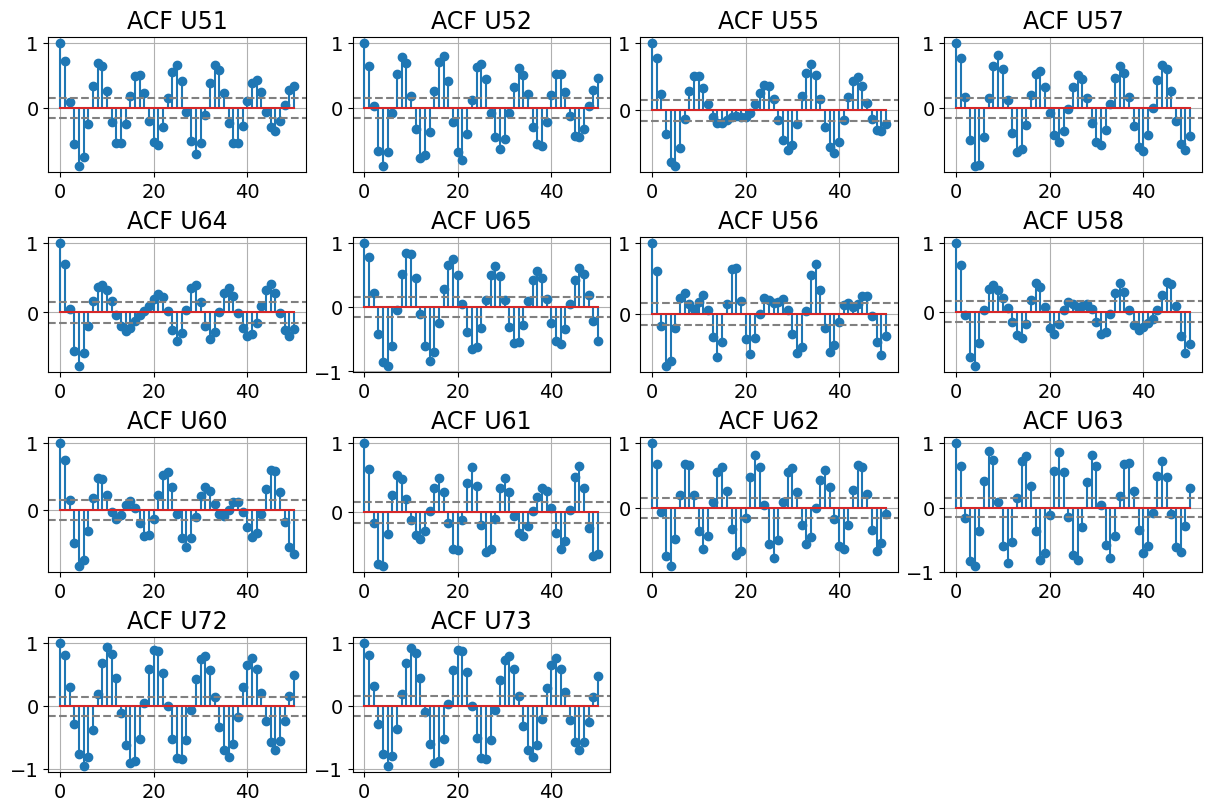

[51, 52, 55, 57, 64, 65, 56, 58, 60, 61, 62, 63, 72, 73]


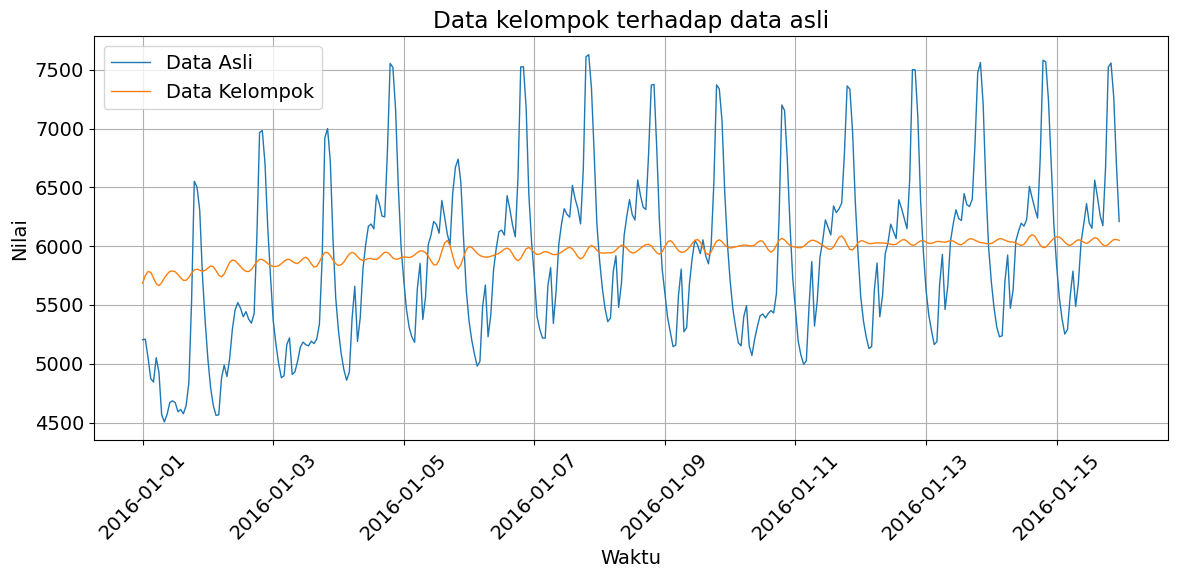

In [33]:
# harian 2
pasangan = [
  [51,52],
  [55,57],
  [64,65],
  [56,58],
  [60,61],
  [62,63],
  [72,73]
]

zoom = [0,0+24*15]

cek_komponen(pasangan, zoom, "kel_harian2")

---
#### **Mingguan**
---

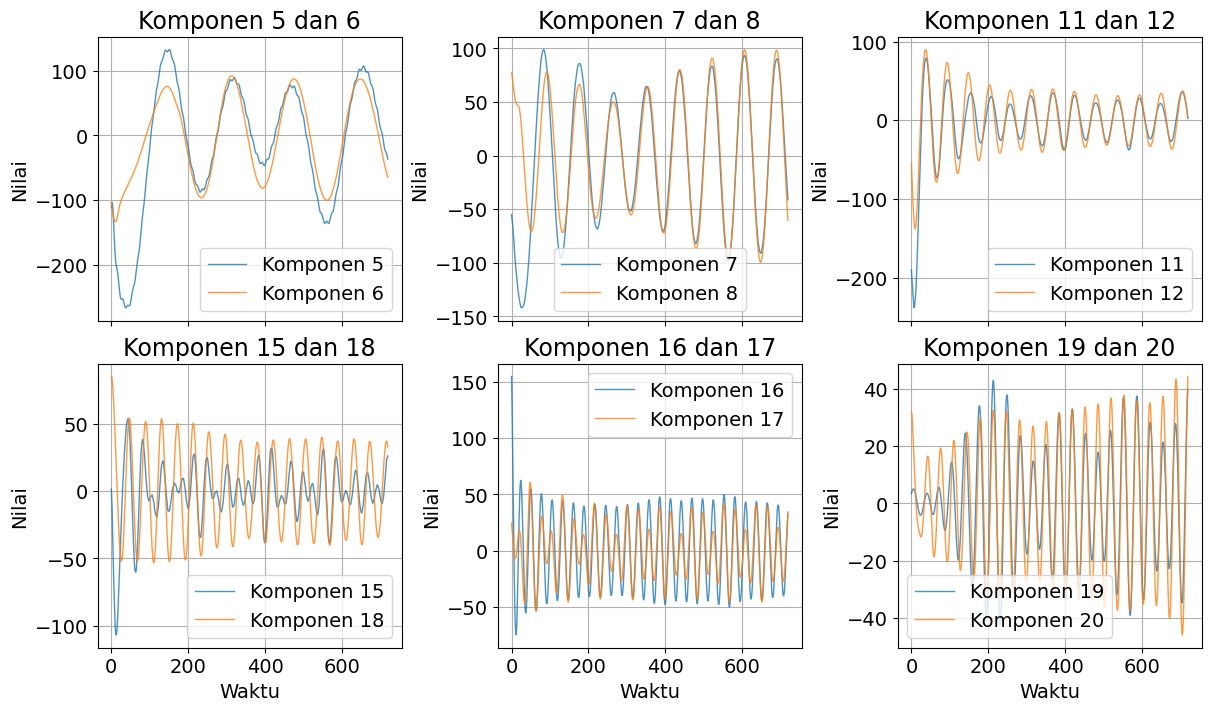

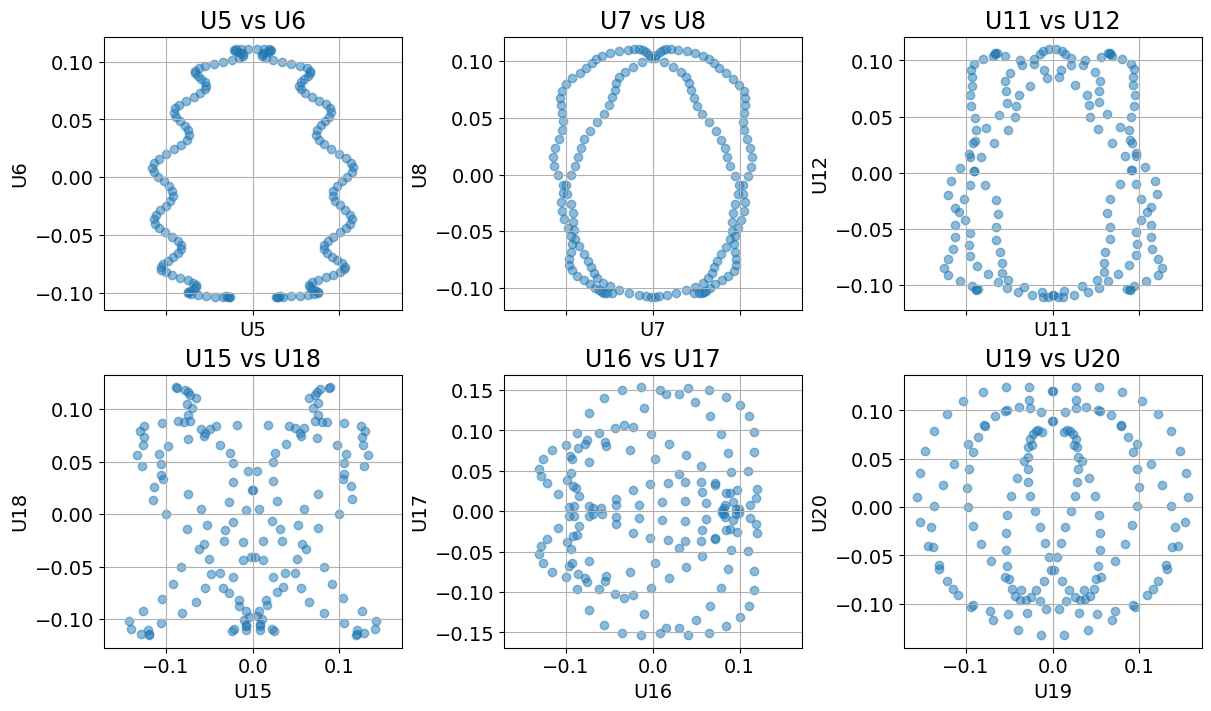

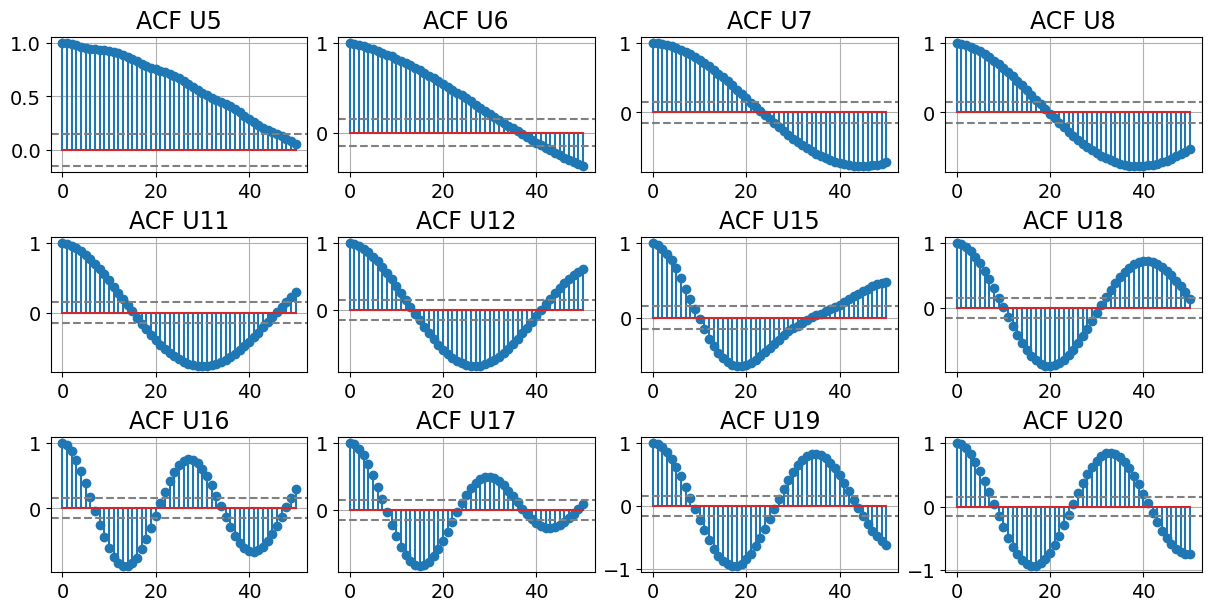

[5, 6, 7, 8, 11, 12, 15, 18, 16, 17, 19, 20]


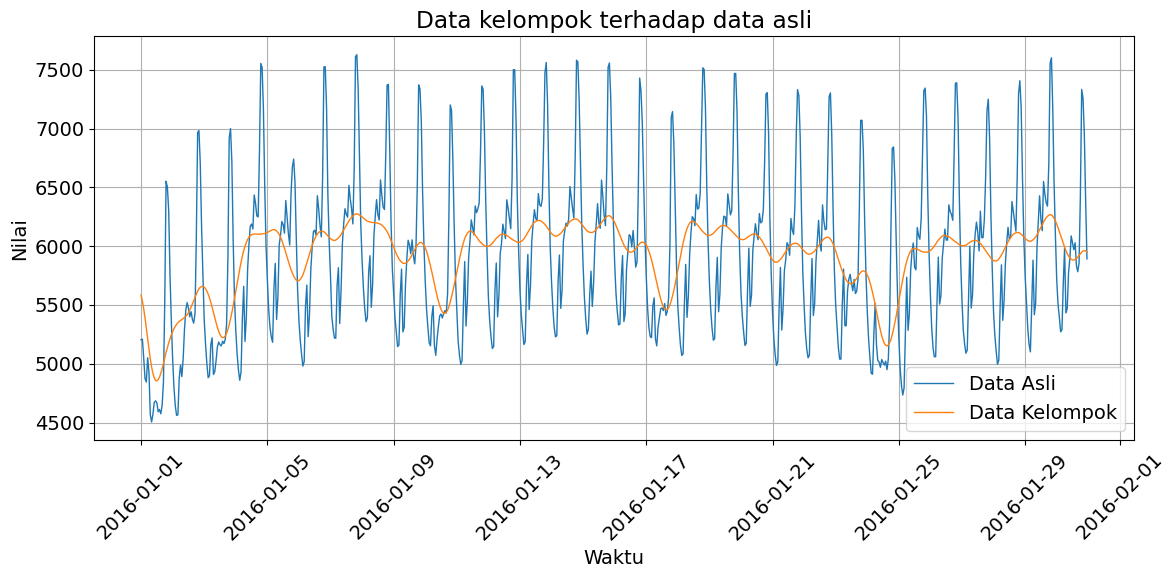

In [34]:
# mingguan 1
pasangan = [
  [5,6],
  [7,8],
  [11,12],
  [15,18],
  [16,17],
  [19,20]

]
zoom = [0,24*30]

cek_komponen(pasangan, zoom, "kel_mingguan1")

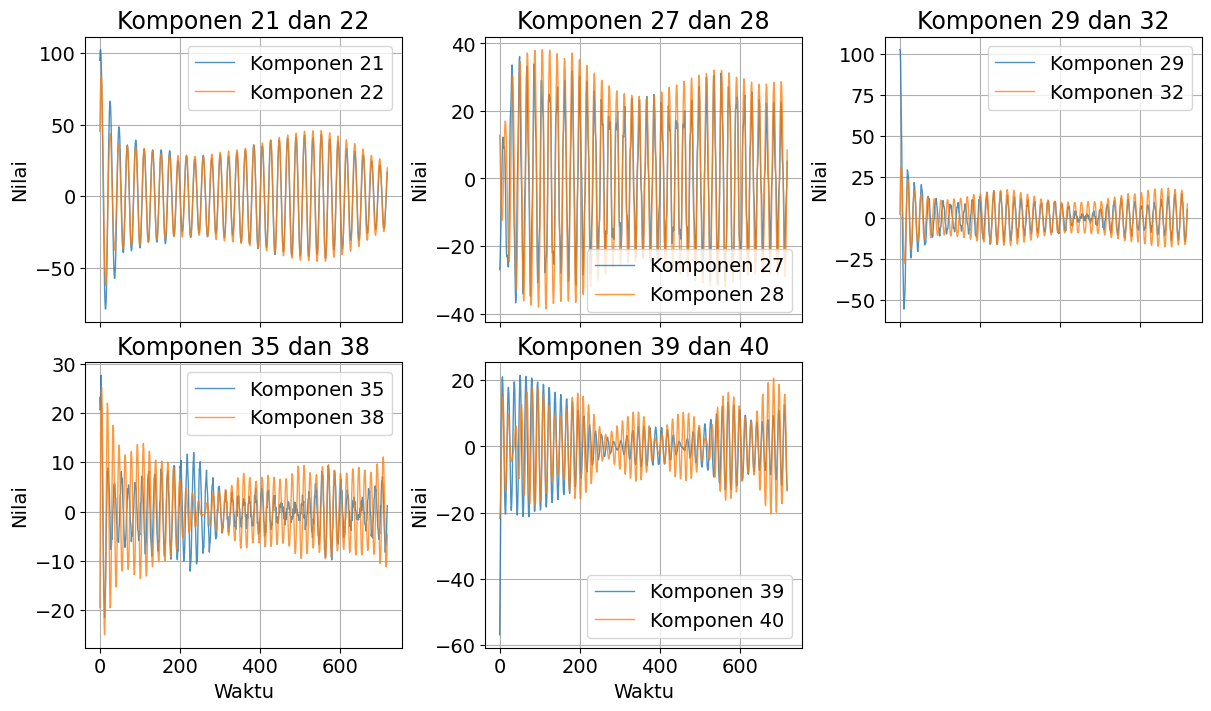

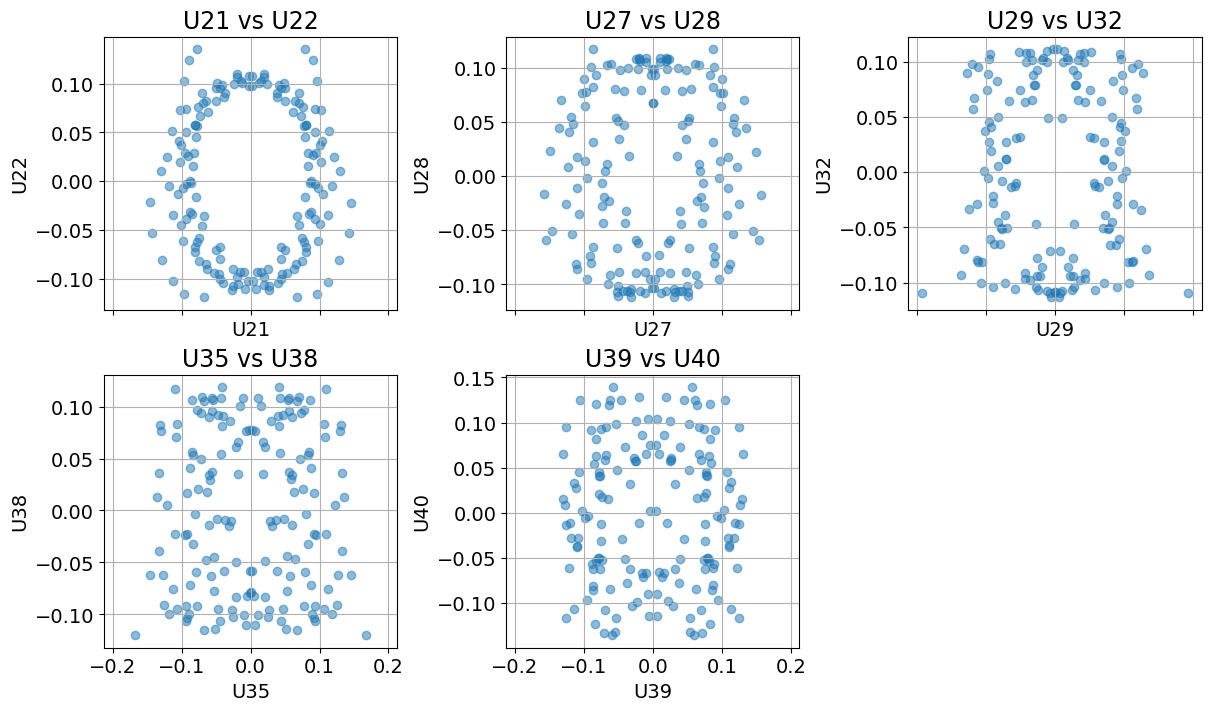

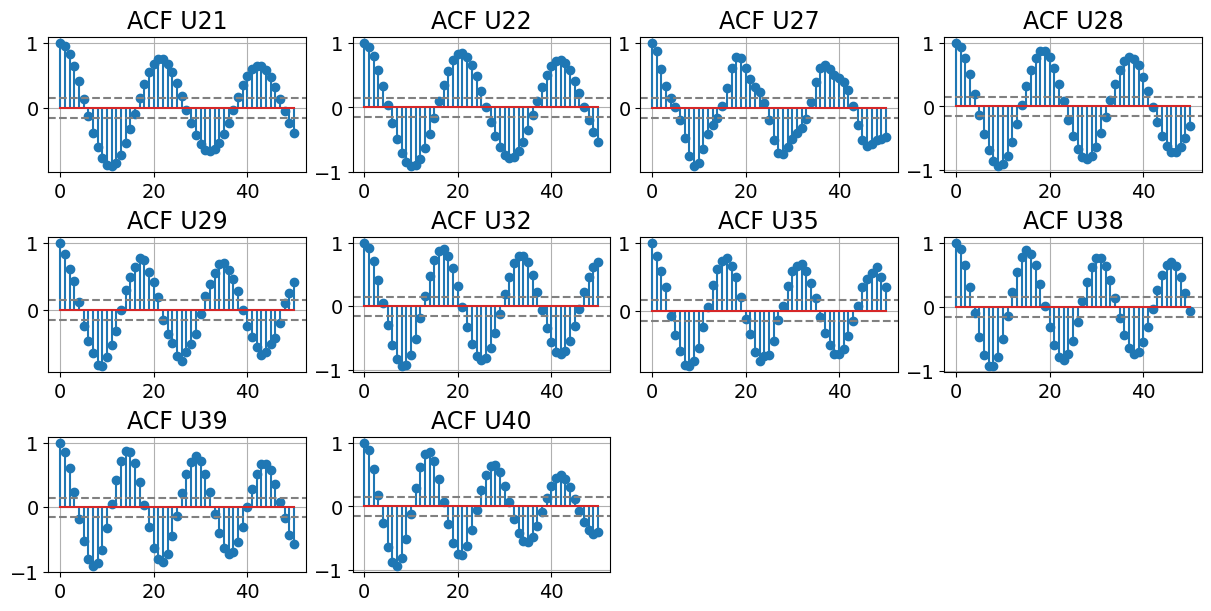

[21, 22, 27, 28, 29, 32, 35, 38, 39, 40]


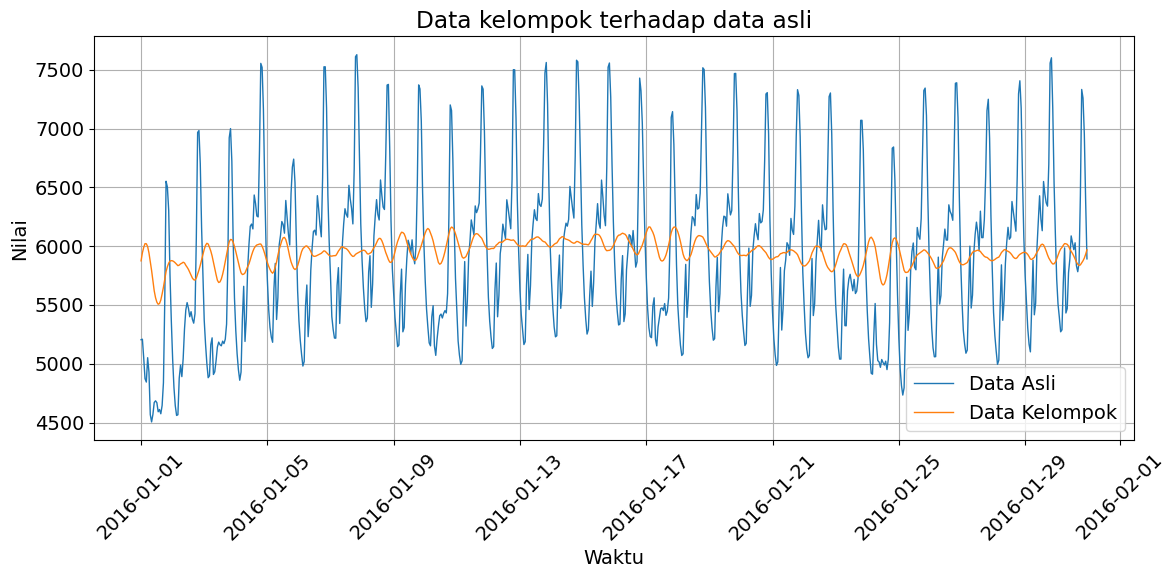

In [35]:
# mingguan 2
pasangan = [
  [21,22],
  [27,28],
  [29,32],
  [35,38],
  [39,40]

]
zoom = [0,24*30]

cek_komponen(pasangan, zoom, "kel_mingguan2")

#### **Noise**

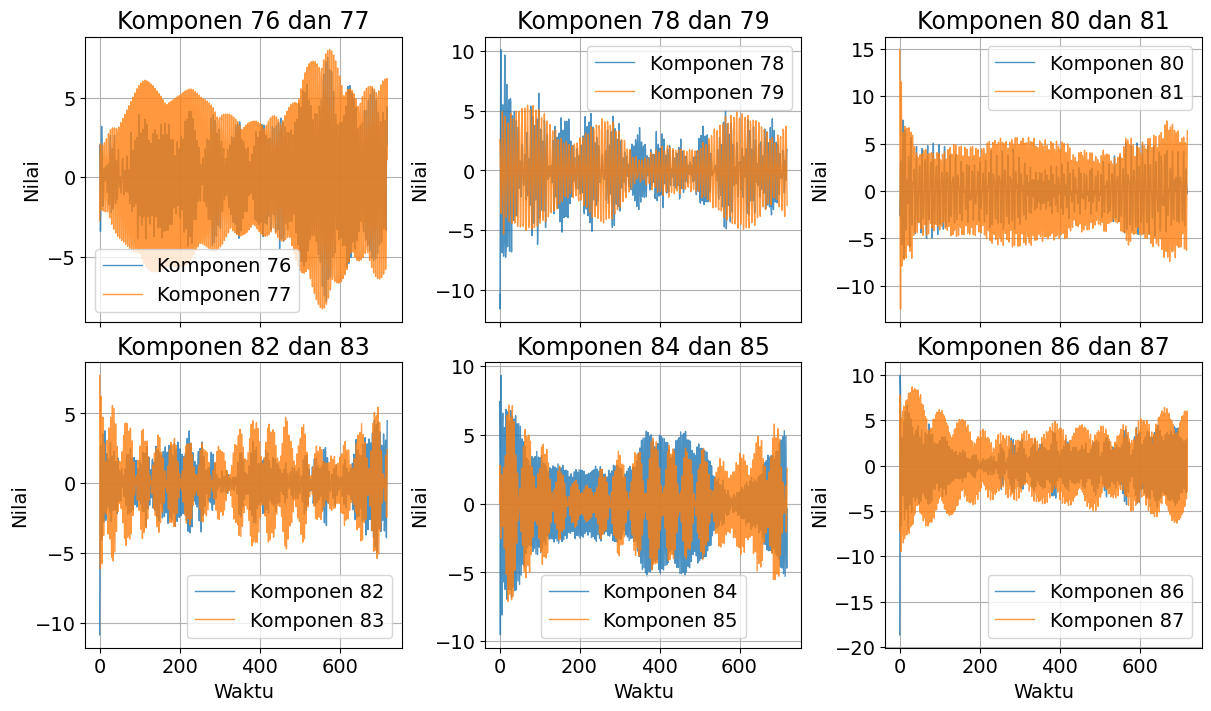

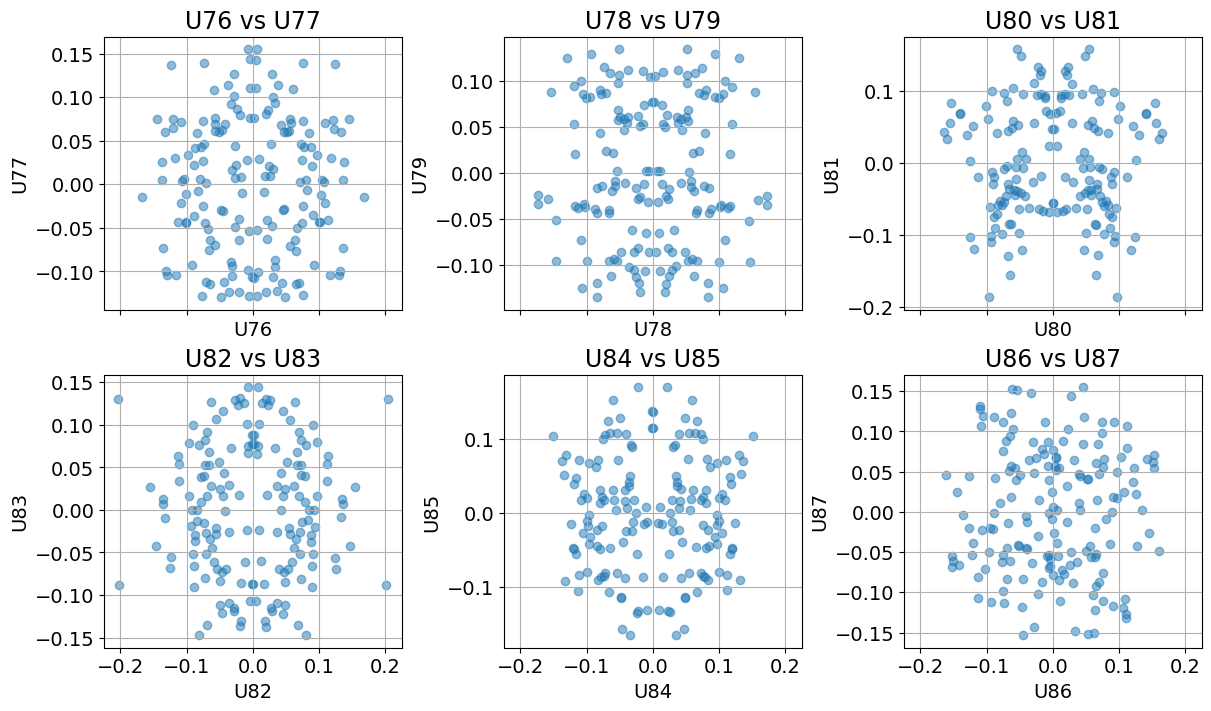

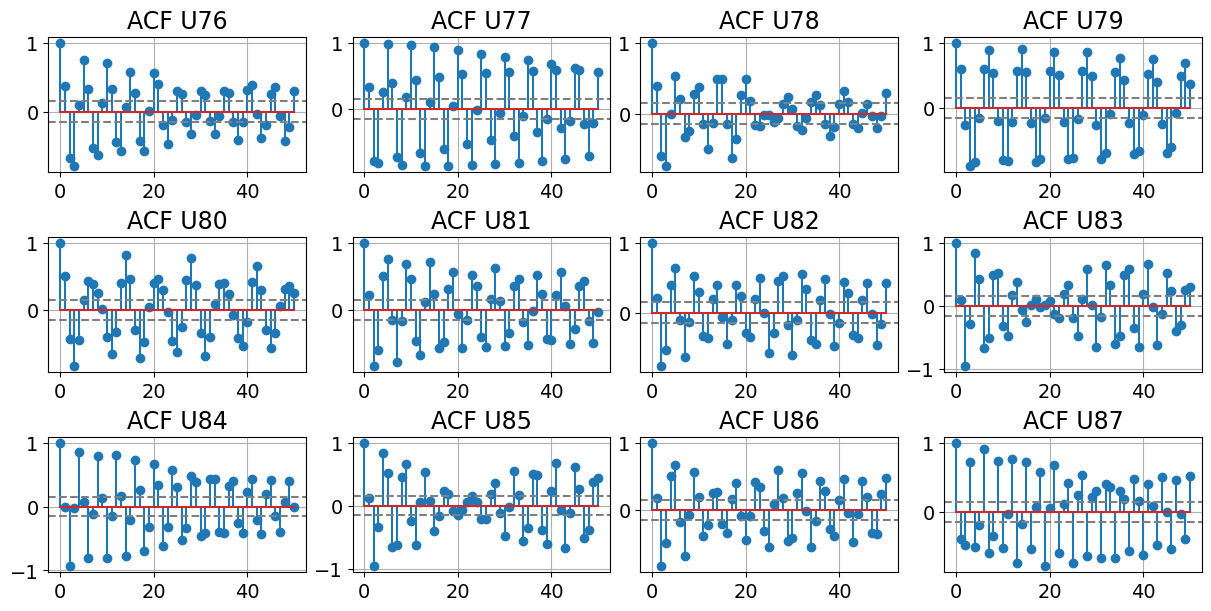

[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]


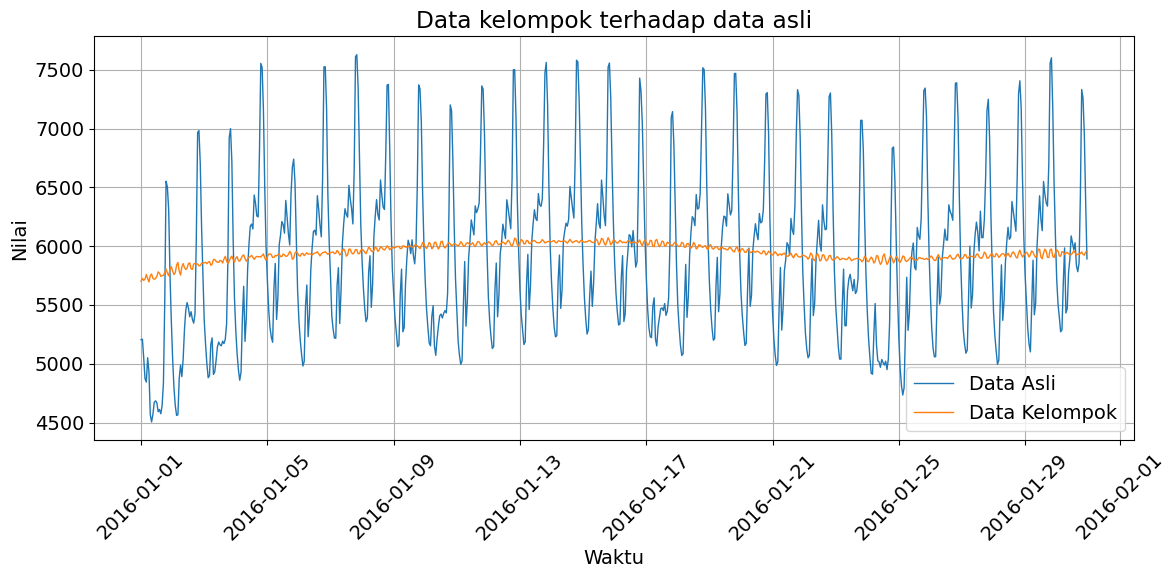

In [36]:
# Noise detected
pasangan = [
    [76,77],
    [78,79],
    [80,81],
    [82,83],
    [84,85],
    [86,87],
    # dst
]
zoom = [0,24*30]

cek_komponen(pasangan, zoom, "kel_noise_sampel")

### **Rekonstruksi**

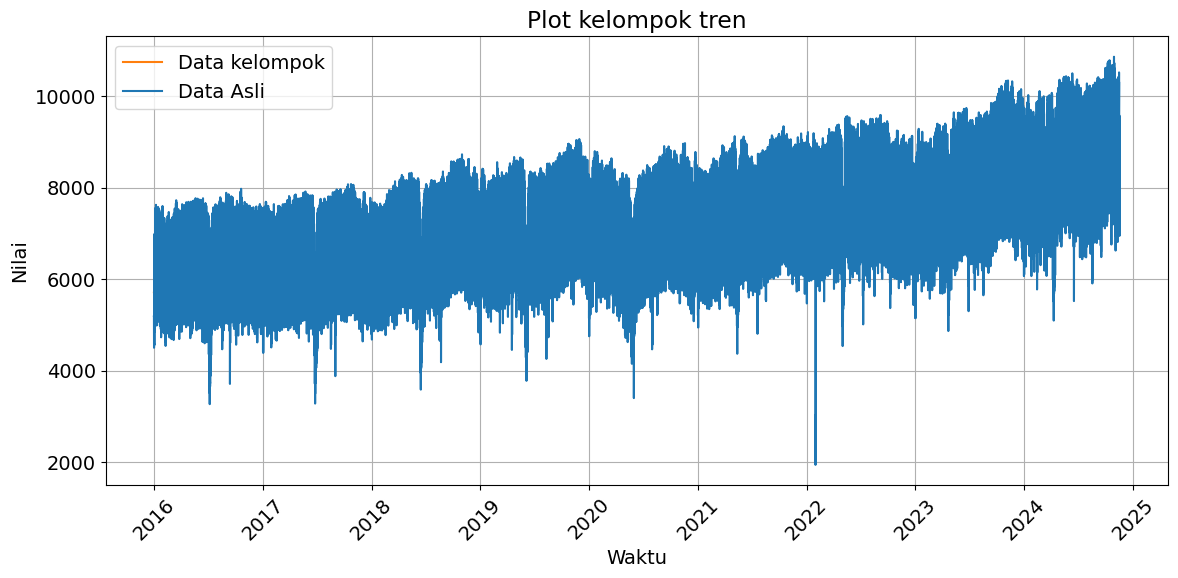

<Figure size 640x480 with 0 Axes>

In [52]:
# Tren
komponen = [0]
zoom = [0,80000]
F_tren = rekonstruk(komponen, zoom, "tren", True)

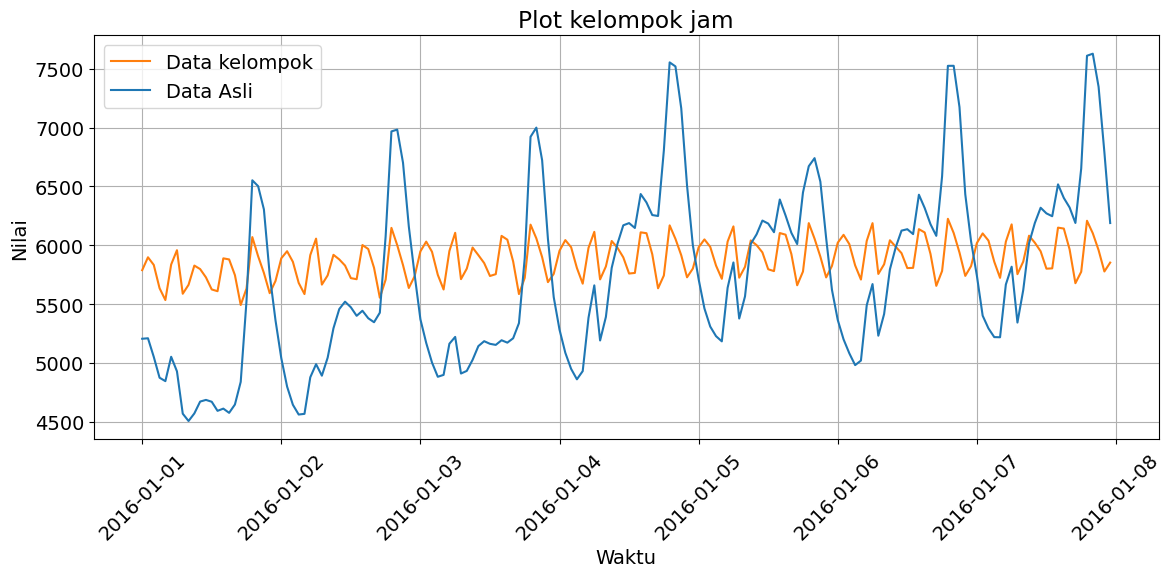

<Figure size 640x480 with 0 Axes>

In [56]:
# Jam
komponen = [13, 14, 23, 24, 30, 31, 33, 34, 36, 37, 41, 42, 53, 54, 25, 26, 47, 48, 49, 50]
zoom = [0,24*7]
F_jam = rekonstruk(komponen, zoom, "jam", True)

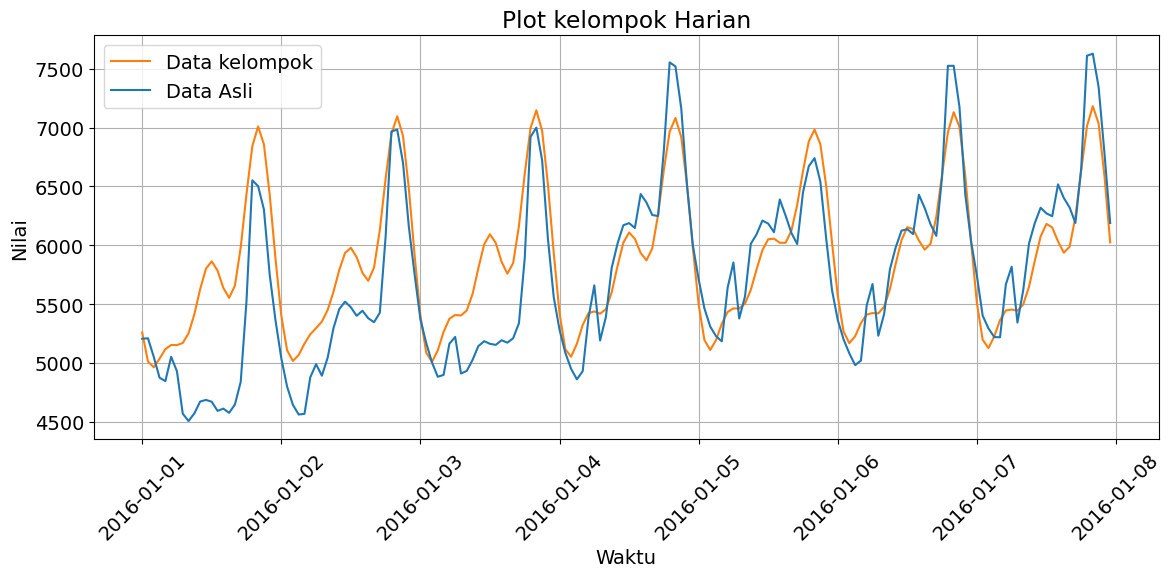

<Figure size 640x480 with 0 Axes>

In [57]:
# Harian
komponen = [1, 2, 3, 4, 9, 10, 43, 44, 51, 52, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 72, 73]
zoom = [0,24*7]
F_harian = rekonstruk(komponen, zoom, "Harian", True)

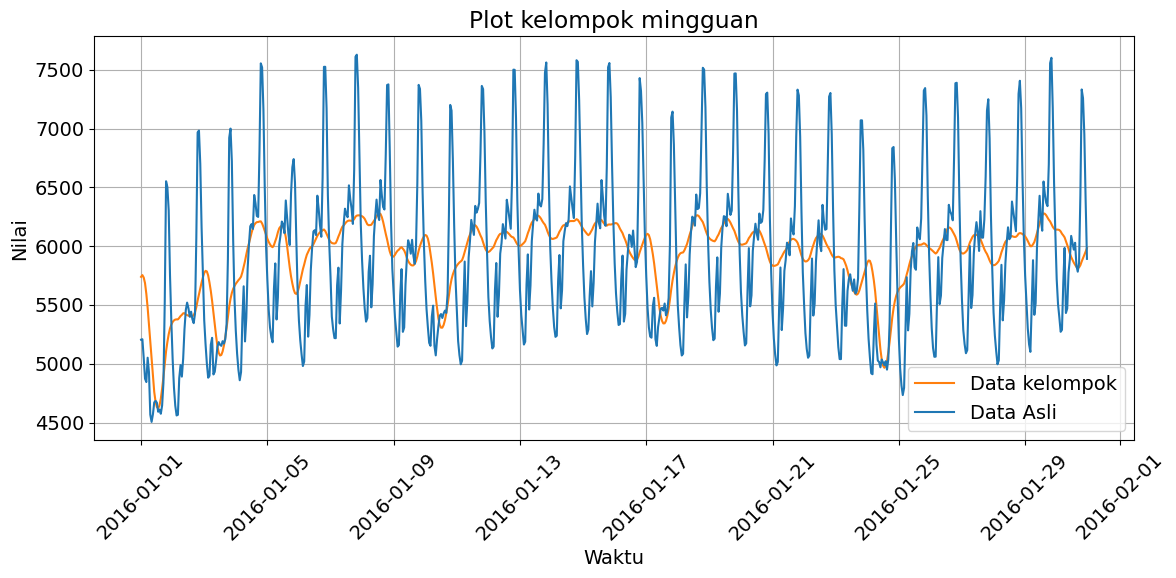

<Figure size 640x480 with 0 Axes>

In [58]:
# Mingguan
komponen = [5, 6, 7, 8, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 32, 35, 38, 39, 40]
zoom = [0,24*30]
F_mingguan = rekonstruk(komponen, zoom, "mingguan", True)

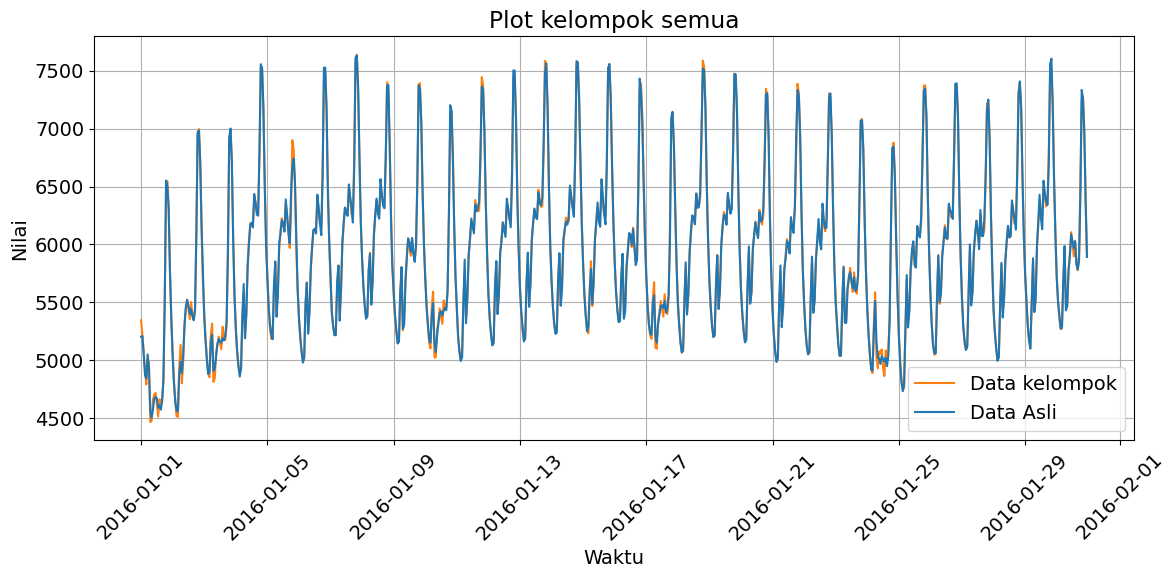

<Figure size 640x480 with 0 Axes>

In [62]:
# Semua
komponen = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 72, 73]
zoom = [0,24*30]
F_rekonstruksi = rekonstruk(komponen, zoom, "semua", True)

In [60]:
F_rekonstruksi = F_tren + F_jam + F_harian + F_mingguan

In [63]:
# Misalkan F_asli dan F_rekonstruksi adalah array numpy dengan panjang yang sama
def evaluate_r2(F_asli, F_rekonstruksi):
    r2 = r2_score(F_asli, F_rekonstruksi)
    return r2

# Contoh penggunaan
F_asli = df_siap['BEBAN'].values  # Data asli
# F_rekonstruksi = F_tren + F_jam + F_harian + F_mingguan_1 + F_mingguan_2  # Data hasil rekonstruksi SSA

mape = np.mean(np.abs((F_asli - F_rekonstruksi) / F_asli)) * 100

akurasi_r2 = evaluate_r2(F_asli, F_rekonstruksi)
akurasi_mape = 100 - mape

print(f"MAPE: {mape:.4f}%")
print(f"R2 Score: {akurasi_r2:.4f}")
print(f"Akurasi: {akurasi_mape:.4f}%")

MAPE: 0.4879%
R2 Score: 0.9984
Akurasi: 99.5121%


Dapat dilihat bahwa data rekonstruksi mewakili sebanyak 99.84% dari data (berdasarkan R2).

In [64]:
np.save(f"{SSA_DATA_PATH}/F_rekonstruksi.npy", F_rekonstruksi)